In [1]:
import numpy as np
import pandas as pd

In [2]:
#Checks if current position is not floating.
def CheckBelow(Environment, X, Y, Z):
    return Z == 0 or (Environment[X,Y,:Z] != '0').all()

#Checks if current position has container.
def CheckPos(Environment, Size, X, Y, Z):
    if not ExceedsLot(Size, X, Y, Z):
        return Environment[X, Y, Z] != '0'
    else:
        return False

#Checks if coordinates exceed lot.
def ExceedsLot(Size, X, Y, Z):
    return Size[2] <= Z or Size[1] <= Y or Size[0] <= X or Z < 0 or Y < 0 or X < 0

#Check whether container is in the middle of other containers.
def CheckMiddle(Environment, Size, X, Y, Z):
    return CheckPos(Environment, Size, X, Y - 1, 0) and CheckPos(Environment, Size, X, Y + 1, 0)

#Adds container to environment using state.
def AddContainer(Environment, Size, State, X, Y, Z):
    tempEnvironment = np.copy(Environment)
    if CheckBelow(Environment, X, Y, Z) and not CheckPos(Environment, Size, X, Y, Z) and not ExceedsLot(Size, X, Y, Z) and not CheckMiddle(Environment, Size, X, Y, Z):
        tempEnvironment[X,Y,Z] = State
    return tempEnvironment
    

In [3]:
#Scores board based on priority :)
#def scoreEnvironment(Environment):
#    result = 0
#    for x in range(Environment.shape[0]):
#        for y in range(Environment.shape[1]):
#            for z in range(Environment.shape[2]):
#                if(Environment[x,y,z] == 'H'):
#                    #print("yes")
#                    #result += (Environment[x,y,z+1:] == 'L').sum()
#                    north = (Environment[x,y:,:] == 'L').sum()
#                    south = (Environment[x,:y+1,:] == 'L').sum()
#                    
#                    result += -(north + south)
#    return result


def scoreEnvironment(Environment):
    result = 0
    for x in range(Environment.shape[0]):
        for y in range(Environment.shape[1]):
            for z in range(Environment.shape[2]):
                result = (Environment[0,:,:] == 'L').sum()
                result -= (Environment[0,:,:] == 'H').sum()
                result -= (Environment[2,:,:] == 'L').sum()
                result += (Environment[2,:,:] == 'H').sum()
    return result


#Returns cleared environment
def clearEnvironment(Environment):
    return np.array([[['0'] * Size[2]] * Size[1]] * Size[0])

#Generate status of board in Boolean array
def GenerateStatusDataset(Environment,dataType):
    return np.concatenate([np.array([dataType == 'H'],dtype=np.float32),np.array(Environment == 'L',dtype=np.float32).flatten(), np.array(Environment == 'H', dtype=np.float32).flatten(), np.array(Environment == '0',dtype=np.float32).flatten()])

In [4]:
Size = (3,3,2)
#High is H
#Low is L

#Generate Environment
c =  [[['0'] * Size[2]] * Size[1]] * Size[0]
cSize = Size[0]*Size[1]*Size[2]*3
actionSize = Size[0]*Size[1]*Size[2]
Speelveld = np.array(c)

In [5]:
Speelveld

array([[['0', '0'],
        ['0', '0'],
        ['0', '0']],

       [['0', '0'],
        ['0', '0'],
        ['0', '0']],

       [['0', '0'],
        ['0', '0'],
        ['0', '0']]], dtype='<U1')

In [6]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

using gpu 3


In [7]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions

In [8]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims = 512, fc2_dims=256)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size,*input_dims), dtype=np.float32)
        
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
    
    def choose_action(self, observation):
        indices = self.action_space.copy()
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [14]:
#TODO: Move learning point to after the episode.

Size = (4,4,1)

#High is H
#Low is L

#Generate Environment
c =  [[['0'] * Size[2]] * Size[1]] * Size[0]
cSize = Size[0]*Size[1]*Size[2]*3  #Set observation space size
actionSize = Size[0]*Size[1]*Size[2] #Set action space size
Speelveld = np.array(c)

#Create agent with properties
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=32, n_actions=actionSize, eps_end=0.01, input_dims = [cSize + 1], lr=0.001)
scores, eps_history, avg_scores = [], [], []

#Number of games
n_games = 1500

for i in range(n_games):
    score = 0
    done = False
    Speelveld = clearEnvironment(Speelveld)
    step = 0
    
    containerList = [np.random.choice(['L','H'])]*actionSize
    #containerList = ['H','L','L','H']
    
    while not done:
        reward = 0
        
        step+=1
        newContainerType = containerList[-1]
        containerList.pop()
        
        #Neural Network
        action = agent.choose_action(GenerateStatusDataset(Speelveld,newContainerType))
        
        #Insert while loop waar alle opties geprobeerd worden.
        nnpred = np.array([0]*Size[2] * Size[1] * Size[0])
        nnpred[action] = 1

        posX, posY, posZ = np.where(nnpred.reshape(Size)==1)

        newSpeelveld = AddContainer(Speelveld, Size, newContainerType, int(posX), int(posY), int(posZ))
        
        
        #Rewarding or punishing agent:
        if np.array_equal(newSpeelveld, Speelveld):
            reward = -5
        else:
            reward = 2
            
                
        #Exit environment if there's been twice too many step s (No need to punish, since it already punishes itself above)
        if(step >= Size[0]*Size[1]*Size[2]):
            done = True
        
        score += reward

        agent.store_transition(GenerateStatusDataset(Speelveld,newContainerType), action, reward, GenerateStatusDataset(newSpeelveld,newContainerType), done)
        agent.learn()
        
        Speelveld = newSpeelveld
        
        scores.append(score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(scores[-100:])
        print("Episode %i score %.2f average score %.2f epsilon %.2f"%(i,score,avg_score,agent.epsilon))
    #print(Speelveld)
    
    avg_scores.append(score)
#    x = [i+1 for i in range(n_games)]

#    plot_learning_curve(x, scores, eps_history, filename)


/tmp/ipykernel_34839/1652483626.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


Episode 0 score 2.00 average score 2.00 epsilon 1.00
Episode 0 score -3.00 average score -0.50 epsilon 1.00
Episode 0 score -1.00 average score -0.67 epsilon 1.00
Episode 0 score 1.00 average score -0.25 epsilon 1.00
Episode 0 score -4.00 average score -1.00 epsilon 1.00
Episode 0 score -2.00 average score -1.17 epsilon 1.00
Episode 0 score 0.00 average score -1.00 epsilon 1.00
Episode 0 score -5.00 average score -1.50 epsilon 1.00
Episode 0 score -3.00 average score -1.67 epsilon 1.00
Episode 0 score -1.00 average score -1.60 epsilon 1.00
Episode 0 score 1.00 average score -1.36 epsilon 1.00
Episode 0 score 3.00 average score -1.00 epsilon 1.00
Episode 0 score -2.00 average score -1.08 epsilon 1.00
Episode 0 score -7.00 average score -1.50 epsilon 1.00
Episode 0 score -5.00 average score -1.73 epsilon 1.00
Episode 0 score -10.00 average score -2.25 epsilon 1.00
Episode 1 score 2.00 average score -2.00 epsilon 1.00
Episode 1 score 4.00 average score -1.67 epsilon 1.00
Episode 1 score 6

Episode 10 score 9.00 average score -3.60 epsilon 0.93
Episode 10 score 11.00 average score -3.52 epsilon 0.93
Episode 10 score 13.00 average score -3.44 epsilon 0.93
Episode 10 score 8.00 average score -3.43 epsilon 0.93
Episode 10 score 10.00 average score -3.42 epsilon 0.93
Episode 10 score 5.00 average score -3.41 epsilon 0.93
Episode 10 score 0.00 average score -3.40 epsilon 0.93
Episode 10 score -5.00 average score -3.39 epsilon 0.93
Episode 10 score -10.00 average score -3.38 epsilon 0.93
Episode 11 score 2.00 average score -3.20 epsilon 0.93
Episode 11 score 4.00 average score -2.95 epsilon 0.93
Episode 11 score 6.00 average score -2.70 epsilon 0.93
Episode 11 score 8.00 average score -2.38 epsilon 0.93
Episode 11 score 10.00 average score -2.30 epsilon 0.93
Episode 11 score 5.00 average score -2.29 epsilon 0.92
Episode 11 score 0.00 average score -2.28 epsilon 0.92
Episode 11 score 2.00 average score -2.27 epsilon 0.92
Episode 11 score -3.00 average score -2.26 epsilon 0.92
Ep

Episode 22 score 8.00 average score -0.21 epsilon 0.84
Episode 22 score 10.00 average score -0.13 epsilon 0.84
Episode 22 score 12.00 average score -0.05 epsilon 0.84
Episode 22 score 14.00 average score 0.03 epsilon 0.84
Episode 22 score 16.00 average score 0.11 epsilon 0.84
Episode 22 score 18.00 average score 0.19 epsilon 0.84
Episode 22 score 13.00 average score 0.27 epsilon 0.83
Episode 22 score 8.00 average score 0.28 epsilon 0.83
Episode 22 score 10.00 average score 0.29 epsilon 0.83
Episode 22 score 12.00 average score 0.37 epsilon 0.83
Episode 22 score 7.00 average score 0.38 epsilon 0.83
Episode 22 score 2.00 average score 0.39 epsilon 0.83
Episode 22 score 4.00 average score 0.40 epsilon 0.83
Episode 23 score 2.00 average score 0.37 epsilon 0.83
Episode 23 score 4.00 average score 0.34 epsilon 0.83
Episode 23 score -1.00 average score 0.31 epsilon 0.83
Episode 23 score 1.00 average score 0.35 epsilon 0.83
Episode 23 score 3.00 average score 0.36 epsilon 0.83
Episode 23 score

Episode 33 score 0.00 average score 3.04 epsilon 0.74
Episode 33 score -5.00 average score 2.91 epsilon 0.74
Episode 33 score -10.00 average score 2.71 epsilon 0.74
Episode 34 score 2.00 average score 2.68 epsilon 0.74
Episode 34 score 4.00 average score 2.72 epsilon 0.74
Episode 34 score 6.00 average score 2.76 epsilon 0.74
Episode 34 score 8.00 average score 2.87 epsilon 0.74
Episode 34 score 3.00 average score 2.88 epsilon 0.74
Episode 34 score 5.00 average score 2.89 epsilon 0.74
Episode 34 score 7.00 average score 2.90 epsilon 0.74
Episode 34 score 2.00 average score 2.84 epsilon 0.74
Episode 34 score -3.00 average score 2.71 epsilon 0.74
Episode 34 score -1.00 average score 2.65 epsilon 0.74
Episode 34 score -6.00 average score 2.52 epsilon 0.74
Episode 34 score -11.00 average score 2.39 epsilon 0.74
Episode 34 score -9.00 average score 2.33 epsilon 0.74
Episode 34 score -7.00 average score 2.27 epsilon 0.74
Episode 34 score -5.00 average score 2.28 epsilon 0.74
Episode 34 score 

Episode 45 score 3.00 average score 6.03 epsilon 0.65
Episode 45 score 5.00 average score 6.04 epsilon 0.65
Episode 45 score 7.00 average score 6.05 epsilon 0.65
Episode 45 score 9.00 average score 6.06 epsilon 0.65
Episode 45 score 11.00 average score 6.07 epsilon 0.65
Episode 45 score 6.00 average score 6.01 epsilon 0.65
Episode 45 score 1.00 average score 5.88 epsilon 0.65
Episode 45 score -4.00 average score 5.68 epsilon 0.65
Episode 45 score -9.00 average score 5.41 epsilon 0.65
Episode 45 score -14.00 average score 5.07 epsilon 0.65
Episode 45 score -19.00 average score 4.66 epsilon 0.65
Episode 45 score -17.00 average score 4.25 epsilon 0.65
Episode 46 score 2.00 average score 4.08 epsilon 0.65
Episode 46 score 4.00 average score 3.98 epsilon 0.65
Episode 46 score 6.00 average score 3.95 epsilon 0.65
Episode 46 score 8.00 average score 3.92 epsilon 0.65
Episode 46 score 10.00 average score 4.00 epsilon 0.65
Episode 46 score 12.00 average score 4.08 epsilon 0.64
Episode 46 score 

Episode 56 score -1.00 average score 4.26 epsilon 0.56
Episode 56 score 1.00 average score 4.20 epsilon 0.56
Episode 56 score 3.00 average score 4.21 epsilon 0.56
Episode 56 score 5.00 average score 4.22 epsilon 0.56
Episode 56 score 0.00 average score 4.23 epsilon 0.56
Episode 56 score 2.00 average score 4.31 epsilon 0.56
Episode 56 score 4.00 average score 4.46 epsilon 0.56
Episode 57 score 2.00 average score 4.64 epsilon 0.56
Episode 57 score 4.00 average score 4.82 epsilon 0.56
Episode 57 score 6.00 average score 5.00 epsilon 0.56
Episode 57 score 8.00 average score 5.25 epsilon 0.56
Episode 57 score 10.00 average score 5.33 epsilon 0.56
Episode 57 score 12.00 average score 5.41 epsilon 0.56
Episode 57 score 7.00 average score 5.42 epsilon 0.56
Episode 57 score 9.00 average score 5.43 epsilon 0.56
Episode 57 score 4.00 average score 5.37 epsilon 0.56
Episode 57 score 6.00 average score 5.38 epsilon 0.55
Episode 57 score 8.00 average score 5.39 epsilon 0.55
Episode 57 score 10.00 av

Episode 67 score -2.00 average score 3.59 epsilon 0.48
Episode 67 score 0.00 average score 3.53 epsilon 0.48
Episode 67 score 2.00 average score 3.47 epsilon 0.48
Episode 67 score -3.00 average score 3.34 epsilon 0.48
Episode 67 score -8.00 average score 3.14 epsilon 0.47
Episode 67 score -6.00 average score 2.94 epsilon 0.47
Episode 67 score -4.00 average score 2.74 epsilon 0.47
Episode 67 score -2.00 average score 2.61 epsilon 0.47
Episode 67 score 0.00 average score 2.55 epsilon 0.47
Episode 67 score 2.00 average score 2.49 epsilon 0.47
Episode 67 score 4.00 average score 2.43 epsilon 0.47
Episode 68 score 2.00 average score 2.33 epsilon 0.47
Episode 68 score 4.00 average score 2.30 epsilon 0.47
Episode 68 score 6.00 average score 2.34 epsilon 0.47
Episode 68 score 8.00 average score 2.45 epsilon 0.47
Episode 68 score 3.00 average score 2.46 epsilon 0.47
Episode 68 score 5.00 average score 2.47 epsilon 0.47
Episode 68 score 7.00 average score 2.48 epsilon 0.47
Episode 68 score 9.00 

Episode 77 score 12.00 average score 7.16 epsilon 0.39
Episode 77 score 7.00 average score 7.17 epsilon 0.39
Episode 77 score 2.00 average score 7.11 epsilon 0.39
Episode 77 score -3.00 average score 6.98 epsilon 0.39
Episode 78 score 2.00 average score 6.88 epsilon 0.39
Episode 78 score 4.00 average score 6.78 epsilon 0.39
Episode 78 score 6.00 average score 6.68 epsilon 0.39
Episode 78 score 8.00 average score 6.65 epsilon 0.39
Episode 78 score 10.00 average score 6.73 epsilon 0.39
Episode 78 score 12.00 average score 6.81 epsilon 0.39
Episode 78 score 14.00 average score 6.89 epsilon 0.39
Episode 78 score 16.00 average score 6.97 epsilon 0.39
Episode 78 score 11.00 average score 6.98 epsilon 0.39
Episode 78 score 13.00 average score 6.99 epsilon 0.39
Episode 78 score 15.00 average score 7.07 epsilon 0.39
Episode 78 score 10.00 average score 7.15 epsilon 0.39
Episode 78 score 12.00 average score 7.23 epsilon 0.39
Episode 78 score 14.00 average score 7.31 epsilon 0.38
Episode 78 score

Episode 88 score 4.00 average score 10.00 epsilon 0.31
Episode 88 score 6.00 average score 10.04 epsilon 0.31
Episode 88 score 8.00 average score 10.08 epsilon 0.31
Episode 88 score 10.00 average score 10.16 epsilon 0.31
Episode 88 score 12.00 average score 10.24 epsilon 0.31
Episode 88 score 14.00 average score 10.32 epsilon 0.31
Episode 88 score 16.00 average score 10.40 epsilon 0.31
Episode 88 score 18.00 average score 10.48 epsilon 0.31
Episode 88 score 20.00 average score 10.63 epsilon 0.31
Episode 88 score 22.00 average score 10.78 epsilon 0.31
Episode 88 score 24.00 average score 10.93 epsilon 0.31
Episode 88 score 19.00 average score 11.01 epsilon 0.31
Episode 88 score 14.00 average score 11.09 epsilon 0.30
Episode 88 score 9.00 average score 11.10 epsilon 0.30
Episode 88 score 4.00 average score 11.11 epsilon 0.30
Episode 89 score 2.00 average score 11.08 epsilon 0.30
Episode 89 score 4.00 average score 11.12 epsilon 0.30
Episode 89 score 6.00 average score 11.16 epsilon 0.30


Episode 98 score 8.00 average score 10.29 epsilon 0.23
Episode 98 score 10.00 average score 10.37 epsilon 0.23
Episode 98 score 12.00 average score 10.45 epsilon 0.23
Episode 98 score 14.00 average score 10.53 epsilon 0.23
Episode 98 score 16.00 average score 10.61 epsilon 0.23
Episode 98 score 18.00 average score 10.69 epsilon 0.23
Episode 98 score 20.00 average score 10.77 epsilon 0.23
Episode 98 score 15.00 average score 10.78 epsilon 0.23
Episode 98 score 17.00 average score 10.79 epsilon 0.23
Episode 98 score 19.00 average score 10.80 epsilon 0.23
Episode 98 score 21.00 average score 10.81 epsilon 0.22
Episode 98 score 16.00 average score 10.75 epsilon 0.22
Episode 98 score 11.00 average score 10.62 epsilon 0.22
Episode 99 score 2.00 average score 10.45 epsilon 0.22
Episode 99 score 4.00 average score 10.35 epsilon 0.22
Episode 99 score 6.00 average score 10.32 epsilon 0.22
Episode 99 score 8.00 average score 10.36 epsilon 0.22
Episode 99 score 10.00 average score 10.44 epsilon 0.

Episode 108 score 5.00 average score 8.35 epsilon 0.15
Episode 108 score 7.00 average score 8.36 epsilon 0.15
Episode 108 score 9.00 average score 8.37 epsilon 0.15
Episode 108 score 11.00 average score 8.38 epsilon 0.15
Episode 108 score 13.00 average score 8.39 epsilon 0.15
Episode 108 score 15.00 average score 8.40 epsilon 0.15
Episode 108 score 17.00 average score 8.41 epsilon 0.15
Episode 108 score 19.00 average score 8.42 epsilon 0.15
Episode 108 score 14.00 average score 8.43 epsilon 0.14
Episode 108 score 9.00 average score 8.37 epsilon 0.14
Episode 108 score 4.00 average score 8.24 epsilon 0.14
Episode 109 score 2.00 average score 8.14 epsilon 0.14
Episode 109 score 4.00 average score 8.11 epsilon 0.14
Episode 109 score 6.00 average score 8.15 epsilon 0.14
Episode 109 score 8.00 average score 8.26 epsilon 0.14
Episode 109 score 10.00 average score 8.34 epsilon 0.14
Episode 109 score 12.00 average score 8.42 epsilon 0.14
Episode 109 score 14.00 average score 8.50 epsilon 0.14
E

Episode 119 score 2.00 average score 11.64 epsilon 0.06
Episode 119 score 4.00 average score 11.47 epsilon 0.06
Episode 119 score 6.00 average score 11.37 epsilon 0.06
Episode 119 score 8.00 average score 11.34 epsilon 0.06
Episode 119 score 10.00 average score 11.42 epsilon 0.06
Episode 119 score 12.00 average score 11.50 epsilon 0.06
Episode 119 score 14.00 average score 11.58 epsilon 0.06
Episode 119 score 16.00 average score 11.66 epsilon 0.06
Episode 119 score 18.00 average score 11.81 epsilon 0.06
Episode 119 score 20.00 average score 11.96 epsilon 0.06
Episode 119 score 22.00 average score 12.11 epsilon 0.06
Episode 119 score 17.00 average score 12.19 epsilon 0.06
Episode 119 score 12.00 average score 12.20 epsilon 0.06
Episode 119 score 7.00 average score 12.14 epsilon 0.06
Episode 119 score 2.00 average score 12.01 epsilon 0.06
Episode 119 score -3.00 average score 11.81 epsilon 0.06
Episode 120 score 2.00 average score 11.64 epsilon 0.06
Episode 120 score 4.00 average score 1

Episode 129 score 10.00 average score 10.65 epsilon 0.01
Episode 129 score 12.00 average score 10.73 epsilon 0.01
Episode 129 score 14.00 average score 10.81 epsilon 0.01
Episode 129 score 16.00 average score 10.89 epsilon 0.01
Episode 129 score 18.00 average score 10.97 epsilon 0.01
Episode 129 score 20.00 average score 11.05 epsilon 0.01
Episode 129 score 22.00 average score 11.13 epsilon 0.01
Episode 129 score 17.00 average score 11.14 epsilon 0.01
Episode 129 score 12.00 average score 11.08 epsilon 0.01
Episode 129 score 7.00 average score 11.02 epsilon 0.01
Episode 129 score 2.00 average score 10.89 epsilon 0.01
Episode 129 score -3.00 average score 10.69 epsilon 0.01
Episode 130 score 2.00 average score 10.52 epsilon 0.01
Episode 130 score 4.00 average score 10.42 epsilon 0.01
Episode 130 score 6.00 average score 10.39 epsilon 0.01
Episode 130 score 8.00 average score 10.43 epsilon 0.01
Episode 130 score 10.00 average score 10.51 epsilon 0.01
Episode 130 score 12.00 average score

Episode 139 score 12.00 average score 12.13 epsilon 0.01
Episode 139 score 14.00 average score 12.21 epsilon 0.01
Episode 139 score 16.00 average score 12.29 epsilon 0.01
Episode 139 score 18.00 average score 12.37 epsilon 0.01
Episode 139 score 20.00 average score 12.45 epsilon 0.01
Episode 139 score 22.00 average score 12.53 epsilon 0.01
Episode 139 score 24.00 average score 12.61 epsilon 0.01
Episode 139 score 19.00 average score 12.62 epsilon 0.01
Episode 139 score 14.00 average score 12.56 epsilon 0.01
Episode 139 score 9.00 average score 12.43 epsilon 0.01
Episode 139 score 4.00 average score 12.23 epsilon 0.01
Episode 140 score 2.00 average score 12.06 epsilon 0.01
Episode 140 score 4.00 average score 11.96 epsilon 0.01
Episode 140 score 6.00 average score 11.93 epsilon 0.01
Episode 140 score 8.00 average score 11.97 epsilon 0.01
Episode 140 score 10.00 average score 12.05 epsilon 0.01
Episode 140 score 12.00 average score 12.13 epsilon 0.01
Episode 140 score 14.00 average score

Episode 149 score 16.00 average score 12.29 epsilon 0.01
Episode 149 score 18.00 average score 12.37 epsilon 0.01
Episode 149 score 20.00 average score 12.45 epsilon 0.01
Episode 149 score 22.00 average score 12.53 epsilon 0.01
Episode 149 score 24.00 average score 12.61 epsilon 0.01
Episode 149 score 19.00 average score 12.62 epsilon 0.01
Episode 149 score 14.00 average score 12.56 epsilon 0.01
Episode 149 score 9.00 average score 12.50 epsilon 0.01
Episode 149 score 4.00 average score 12.44 epsilon 0.01
Episode 150 score 2.00 average score 12.41 epsilon 0.01
Episode 150 score 4.00 average score 12.45 epsilon 0.01
Episode 150 score 6.00 average score 12.49 epsilon 0.01
Episode 150 score 8.00 average score 12.60 epsilon 0.01
Episode 150 score 10.00 average score 12.68 epsilon 0.01
Episode 150 score 12.00 average score 12.76 epsilon 0.01
Episode 150 score 14.00 average score 12.84 epsilon 0.01
Episode 150 score 16.00 average score 12.92 epsilon 0.01
Episode 150 score 18.00 average score

Episode 159 score 18.00 average score 12.72 epsilon 0.01
Episode 159 score 20.00 average score 12.80 epsilon 0.01
Episode 159 score 22.00 average score 12.88 epsilon 0.01
Episode 159 score 24.00 average score 12.96 epsilon 0.01
Episode 159 score 19.00 average score 12.97 epsilon 0.01
Episode 159 score 14.00 average score 12.91 epsilon 0.01
Episode 159 score 9.00 average score 12.78 epsilon 0.01
Episode 159 score 4.00 average score 12.58 epsilon 0.01
Episode 160 score 2.00 average score 12.41 epsilon 0.01
Episode 160 score 4.00 average score 12.31 epsilon 0.01
Episode 160 score 6.00 average score 12.28 epsilon 0.01
Episode 160 score 8.00 average score 12.32 epsilon 0.01
Episode 160 score 10.00 average score 12.40 epsilon 0.01
Episode 160 score 12.00 average score 12.48 epsilon 0.01
Episode 160 score 14.00 average score 12.56 epsilon 0.01
Episode 160 score 16.00 average score 12.64 epsilon 0.01
Episode 160 score 18.00 average score 12.72 epsilon 0.01
Episode 160 score 20.00 average score

Episode 169 score 18.00 average score 12.72 epsilon 0.01
Episode 169 score 20.00 average score 12.80 epsilon 0.01
Episode 169 score 22.00 average score 12.88 epsilon 0.01
Episode 169 score 24.00 average score 12.96 epsilon 0.01
Episode 169 score 19.00 average score 12.97 epsilon 0.01
Episode 169 score 14.00 average score 12.91 epsilon 0.01
Episode 169 score 9.00 average score 12.78 epsilon 0.01
Episode 169 score 4.00 average score 12.58 epsilon 0.01
Episode 170 score 2.00 average score 12.41 epsilon 0.01
Episode 170 score 4.00 average score 12.31 epsilon 0.01
Episode 170 score 6.00 average score 12.28 epsilon 0.01
Episode 170 score 8.00 average score 12.32 epsilon 0.01
Episode 170 score 10.00 average score 12.40 epsilon 0.01
Episode 170 score 12.00 average score 12.48 epsilon 0.01
Episode 170 score 14.00 average score 12.56 epsilon 0.01
Episode 170 score 16.00 average score 12.64 epsilon 0.01
Episode 170 score 18.00 average score 12.72 epsilon 0.01
Episode 170 score 20.00 average score

Episode 179 score 18.00 average score 12.72 epsilon 0.01
Episode 179 score 20.00 average score 12.80 epsilon 0.01
Episode 179 score 22.00 average score 12.88 epsilon 0.01
Episode 179 score 24.00 average score 12.96 epsilon 0.01
Episode 179 score 19.00 average score 12.97 epsilon 0.01
Episode 179 score 14.00 average score 12.91 epsilon 0.01
Episode 179 score 9.00 average score 12.78 epsilon 0.01
Episode 179 score 4.00 average score 12.58 epsilon 0.01
Episode 180 score 2.00 average score 12.41 epsilon 0.01
Episode 180 score 4.00 average score 12.31 epsilon 0.01
Episode 180 score 6.00 average score 12.28 epsilon 0.01
Episode 180 score 8.00 average score 12.32 epsilon 0.01
Episode 180 score 10.00 average score 12.40 epsilon 0.01
Episode 180 score 12.00 average score 12.48 epsilon 0.01
Episode 180 score 14.00 average score 12.56 epsilon 0.01
Episode 180 score 16.00 average score 12.64 epsilon 0.01
Episode 180 score 18.00 average score 12.72 epsilon 0.01
Episode 180 score 20.00 average score

Episode 189 score 16.00 average score 12.92 epsilon 0.01
Episode 189 score 18.00 average score 13.00 epsilon 0.01
Episode 189 score 20.00 average score 13.08 epsilon 0.01
Episode 189 score 22.00 average score 13.16 epsilon 0.01
Episode 189 score 24.00 average score 13.24 epsilon 0.01
Episode 189 score 19.00 average score 13.25 epsilon 0.01
Episode 189 score 14.00 average score 13.19 epsilon 0.01
Episode 189 score 9.00 average score 13.06 epsilon 0.01
Episode 189 score 4.00 average score 12.86 epsilon 0.01
Episode 190 score 2.00 average score 12.69 epsilon 0.01
Episode 190 score 4.00 average score 12.59 epsilon 0.01
Episode 190 score 6.00 average score 12.56 epsilon 0.01
Episode 190 score 8.00 average score 12.60 epsilon 0.01
Episode 190 score 10.00 average score 12.68 epsilon 0.01
Episode 190 score 12.00 average score 12.76 epsilon 0.01
Episode 190 score 14.00 average score 12.84 epsilon 0.01
Episode 190 score 16.00 average score 12.92 epsilon 0.01
Episode 190 score 18.00 average score

Episode 199 score 12.00 average score 12.76 epsilon 0.01
Episode 199 score 14.00 average score 12.84 epsilon 0.01
Episode 199 score 16.00 average score 12.92 epsilon 0.01
Episode 199 score 18.00 average score 13.00 epsilon 0.01
Episode 199 score 20.00 average score 13.08 epsilon 0.01
Episode 199 score 22.00 average score 13.16 epsilon 0.01
Episode 199 score 24.00 average score 13.24 epsilon 0.01
Episode 199 score 19.00 average score 13.25 epsilon 0.01
Episode 199 score 14.00 average score 13.19 epsilon 0.01
Episode 199 score 9.00 average score 13.06 epsilon 0.01
Episode 199 score 4.00 average score 12.86 epsilon 0.01
Episode 200 score 2.00 average score 12.69 epsilon 0.01
Episode 200 score 4.00 average score 12.59 epsilon 0.01
Episode 200 score 6.00 average score 12.56 epsilon 0.01
Episode 200 score 8.00 average score 12.60 epsilon 0.01
Episode 200 score 10.00 average score 12.68 epsilon 0.01
Episode 200 score 12.00 average score 12.76 epsilon 0.01
Episode 200 score 14.00 average score

Episode 209 score 10.00 average score 12.68 epsilon 0.01
Episode 209 score 12.00 average score 12.76 epsilon 0.01
Episode 209 score 14.00 average score 12.84 epsilon 0.01
Episode 209 score 16.00 average score 12.92 epsilon 0.01
Episode 209 score 18.00 average score 13.00 epsilon 0.01
Episode 209 score 20.00 average score 13.08 epsilon 0.01
Episode 209 score 22.00 average score 13.16 epsilon 0.01
Episode 209 score 24.00 average score 13.24 epsilon 0.01
Episode 209 score 19.00 average score 13.25 epsilon 0.01
Episode 209 score 14.00 average score 13.19 epsilon 0.01
Episode 209 score 9.00 average score 13.06 epsilon 0.01
Episode 209 score 4.00 average score 12.86 epsilon 0.01
Episode 210 score 2.00 average score 12.69 epsilon 0.01
Episode 210 score 4.00 average score 12.59 epsilon 0.01
Episode 210 score 6.00 average score 12.56 epsilon 0.01
Episode 210 score 8.00 average score 12.60 epsilon 0.01
Episode 210 score 10.00 average score 12.68 epsilon 0.01
Episode 210 score 12.00 average score

Episode 219 score 6.00 average score 12.28 epsilon 0.01
Episode 219 score 8.00 average score 12.32 epsilon 0.01
Episode 219 score 10.00 average score 12.40 epsilon 0.01
Episode 219 score 12.00 average score 12.48 epsilon 0.01
Episode 219 score 14.00 average score 12.56 epsilon 0.01
Episode 219 score 16.00 average score 12.64 epsilon 0.01
Episode 219 score 18.00 average score 12.72 epsilon 0.01
Episode 219 score 20.00 average score 12.80 epsilon 0.01
Episode 219 score 22.00 average score 12.88 epsilon 0.01
Episode 219 score 24.00 average score 12.96 epsilon 0.01
Episode 219 score 26.00 average score 13.04 epsilon 0.01
Episode 219 score 21.00 average score 13.05 epsilon 0.01
Episode 219 score 16.00 average score 12.99 epsilon 0.01
Episode 219 score 11.00 average score 12.86 epsilon 0.01
Episode 220 score 2.00 average score 12.69 epsilon 0.01
Episode 220 score 4.00 average score 12.59 epsilon 0.01
Episode 220 score 6.00 average score 12.56 epsilon 0.01
Episode 220 score 8.00 average score

Episode 229 score 18.00 average score 13.00 epsilon 0.01
Episode 229 score 20.00 average score 13.08 epsilon 0.01
Episode 229 score 22.00 average score 13.16 epsilon 0.01
Episode 229 score 24.00 average score 13.24 epsilon 0.01
Episode 229 score 19.00 average score 13.25 epsilon 0.01
Episode 229 score 14.00 average score 13.19 epsilon 0.01
Episode 229 score 9.00 average score 13.06 epsilon 0.01
Episode 229 score 4.00 average score 12.86 epsilon 0.01
Episode 230 score 2.00 average score 12.69 epsilon 0.01
Episode 230 score 4.00 average score 12.59 epsilon 0.01
Episode 230 score 6.00 average score 12.56 epsilon 0.01
Episode 230 score 8.00 average score 12.60 epsilon 0.01
Episode 230 score 10.00 average score 12.68 epsilon 0.01
Episode 230 score 12.00 average score 12.76 epsilon 0.01
Episode 230 score 14.00 average score 12.84 epsilon 0.01
Episode 230 score 16.00 average score 12.92 epsilon 0.01
Episode 230 score 18.00 average score 13.00 epsilon 0.01
Episode 230 score 20.00 average score

Episode 240 score 6.00 average score 12.56 epsilon 0.01
Episode 240 score 8.00 average score 12.60 epsilon 0.01
Episode 240 score 10.00 average score 12.68 epsilon 0.01
Episode 240 score 12.00 average score 12.76 epsilon 0.01
Episode 240 score 14.00 average score 12.84 epsilon 0.01
Episode 240 score 16.00 average score 12.92 epsilon 0.01
Episode 240 score 18.00 average score 13.00 epsilon 0.01
Episode 240 score 20.00 average score 13.08 epsilon 0.01
Episode 240 score 22.00 average score 13.16 epsilon 0.01
Episode 240 score 24.00 average score 13.24 epsilon 0.01
Episode 240 score 19.00 average score 13.25 epsilon 0.01
Episode 240 score 14.00 average score 13.19 epsilon 0.01
Episode 240 score 9.00 average score 13.06 epsilon 0.01
Episode 240 score 4.00 average score 12.86 epsilon 0.01
Episode 241 score 2.00 average score 12.69 epsilon 0.01
Episode 241 score 4.00 average score 12.59 epsilon 0.01
Episode 241 score 6.00 average score 12.56 epsilon 0.01
Episode 241 score 8.00 average score 1

Episode 250 score 22.00 average score 13.44 epsilon 0.01
Episode 250 score 24.00 average score 13.52 epsilon 0.01
Episode 250 score 19.00 average score 13.53 epsilon 0.01
Episode 250 score 14.00 average score 13.47 epsilon 0.01
Episode 250 score 9.00 average score 13.34 epsilon 0.01
Episode 250 score 4.00 average score 13.14 epsilon 0.01
Episode 251 score 2.00 average score 12.90 epsilon 0.01
Episode 251 score 4.00 average score 12.73 epsilon 0.01
Episode 251 score 6.00 average score 12.63 epsilon 0.01
Episode 251 score 8.00 average score 12.60 epsilon 0.01
Episode 251 score 10.00 average score 12.68 epsilon 0.01
Episode 251 score 12.00 average score 12.76 epsilon 0.01
Episode 251 score 14.00 average score 12.84 epsilon 0.01
Episode 251 score 16.00 average score 12.92 epsilon 0.01
Episode 251 score 18.00 average score 13.00 epsilon 0.01
Episode 251 score 20.00 average score 13.08 epsilon 0.01
Episode 251 score 22.00 average score 13.16 epsilon 0.01
Episode 251 score 24.00 average score

Episode 260 score 4.00 average score 12.86 epsilon 0.01
Episode 261 score 2.00 average score 12.69 epsilon 0.01
Episode 261 score 4.00 average score 12.59 epsilon 0.01
Episode 261 score 6.00 average score 12.56 epsilon 0.01
Episode 261 score 8.00 average score 12.60 epsilon 0.01
Episode 261 score 10.00 average score 12.68 epsilon 0.01
Episode 261 score 12.00 average score 12.76 epsilon 0.01
Episode 261 score 14.00 average score 12.84 epsilon 0.01
Episode 261 score 16.00 average score 12.92 epsilon 0.01
Episode 261 score 18.00 average score 13.00 epsilon 0.01
Episode 261 score 20.00 average score 13.08 epsilon 0.01
Episode 261 score 22.00 average score 13.16 epsilon 0.01
Episode 261 score 24.00 average score 13.24 epsilon 0.01
Episode 261 score 19.00 average score 13.25 epsilon 0.01
Episode 261 score 14.00 average score 13.19 epsilon 0.01
Episode 261 score 9.00 average score 13.06 epsilon 0.01
Episode 261 score 4.00 average score 12.86 epsilon 0.01
Episode 262 score 2.00 average score 1

Episode 271 score 16.00 average score 13.20 epsilon 0.01
Episode 271 score 18.00 average score 13.28 epsilon 0.01
Episode 271 score 20.00 average score 13.36 epsilon 0.01
Episode 271 score 22.00 average score 13.44 epsilon 0.01
Episode 271 score 24.00 average score 13.52 epsilon 0.01
Episode 271 score 19.00 average score 13.53 epsilon 0.01
Episode 271 score 14.00 average score 13.47 epsilon 0.01
Episode 271 score 9.00 average score 13.34 epsilon 0.01
Episode 271 score 4.00 average score 13.14 epsilon 0.01
Episode 272 score 2.00 average score 12.90 epsilon 0.01
Episode 272 score 4.00 average score 12.73 epsilon 0.01
Episode 272 score 6.00 average score 12.63 epsilon 0.01
Episode 272 score 8.00 average score 12.60 epsilon 0.01
Episode 272 score 10.00 average score 12.68 epsilon 0.01
Episode 272 score 12.00 average score 12.76 epsilon 0.01
Episode 272 score 14.00 average score 12.84 epsilon 0.01
Episode 272 score 16.00 average score 12.92 epsilon 0.01
Episode 272 score 18.00 average score

Episode 281 score 4.00 average score 12.58 epsilon 0.01
Episode 282 score 2.00 average score 12.41 epsilon 0.01
Episode 282 score 4.00 average score 12.31 epsilon 0.01
Episode 282 score 6.00 average score 12.28 epsilon 0.01
Episode 282 score 8.00 average score 12.32 epsilon 0.01
Episode 282 score 10.00 average score 12.40 epsilon 0.01
Episode 282 score 12.00 average score 12.48 epsilon 0.01
Episode 282 score 14.00 average score 12.56 epsilon 0.01
Episode 282 score 16.00 average score 12.64 epsilon 0.01
Episode 282 score 18.00 average score 12.72 epsilon 0.01
Episode 282 score 20.00 average score 12.80 epsilon 0.01
Episode 282 score 22.00 average score 12.88 epsilon 0.01
Episode 282 score 24.00 average score 12.96 epsilon 0.01
Episode 282 score 19.00 average score 12.97 epsilon 0.01
Episode 282 score 14.00 average score 12.91 epsilon 0.01
Episode 282 score 9.00 average score 12.78 epsilon 0.01
Episode 282 score 4.00 average score 12.58 epsilon 0.01
Episode 283 score 2.00 average score 1

Episode 292 score 2.00 average score 11.57 epsilon 0.01
Episode 292 score 4.00 average score 11.47 epsilon 0.01
Episode 292 score 6.00 average score 11.44 epsilon 0.01
Episode 292 score 8.00 average score 11.48 epsilon 0.01
Episode 292 score 10.00 average score 11.56 epsilon 0.01
Episode 292 score 12.00 average score 11.64 epsilon 0.01
Episode 292 score 14.00 average score 11.72 epsilon 0.01
Episode 292 score 16.00 average score 11.87 epsilon 0.01
Episode 292 score 18.00 average score 12.02 epsilon 0.01
Episode 292 score 20.00 average score 12.17 epsilon 0.01
Episode 292 score 22.00 average score 12.32 epsilon 0.01
Episode 292 score 24.00 average score 12.47 epsilon 0.01
Episode 292 score 19.00 average score 12.55 epsilon 0.01
Episode 292 score 14.00 average score 12.56 epsilon 0.01
Episode 292 score 9.00 average score 12.50 epsilon 0.01
Episode 292 score 4.00 average score 12.37 epsilon 0.01
Episode 293 score 2.00 average score 12.20 epsilon 0.01
Episode 293 score 4.00 average score 1

Episode 302 score 2.00 average score 12.41 epsilon 0.01
Episode 302 score 4.00 average score 12.31 epsilon 0.01
Episode 302 score 6.00 average score 12.28 epsilon 0.01
Episode 302 score 8.00 average score 12.32 epsilon 0.01
Episode 302 score 10.00 average score 12.40 epsilon 0.01
Episode 302 score 12.00 average score 12.48 epsilon 0.01
Episode 302 score 14.00 average score 12.56 epsilon 0.01
Episode 302 score 16.00 average score 12.64 epsilon 0.01
Episode 302 score 18.00 average score 12.72 epsilon 0.01
Episode 302 score 20.00 average score 12.80 epsilon 0.01
Episode 302 score 22.00 average score 12.88 epsilon 0.01
Episode 302 score 24.00 average score 12.96 epsilon 0.01
Episode 302 score 19.00 average score 12.97 epsilon 0.01
Episode 302 score 14.00 average score 12.91 epsilon 0.01
Episode 302 score 9.00 average score 12.78 epsilon 0.01
Episode 302 score 4.00 average score 12.58 epsilon 0.01
Episode 303 score 2.00 average score 12.41 epsilon 0.01
Episode 303 score 4.00 average score 1

Episode 312 score 8.00 average score 12.60 epsilon 0.01
Episode 312 score 10.00 average score 12.68 epsilon 0.01
Episode 312 score 12.00 average score 12.76 epsilon 0.01
Episode 312 score 14.00 average score 12.84 epsilon 0.01
Episode 312 score 16.00 average score 12.92 epsilon 0.01
Episode 312 score 18.00 average score 13.00 epsilon 0.01
Episode 312 score 20.00 average score 13.08 epsilon 0.01
Episode 312 score 22.00 average score 13.16 epsilon 0.01
Episode 312 score 24.00 average score 13.24 epsilon 0.01
Episode 312 score 19.00 average score 13.25 epsilon 0.01
Episode 312 score 14.00 average score 13.19 epsilon 0.01
Episode 312 score 9.00 average score 13.06 epsilon 0.01
Episode 312 score 4.00 average score 12.86 epsilon 0.01
Episode 313 score 2.00 average score 12.69 epsilon 0.01
Episode 313 score 4.00 average score 12.59 epsilon 0.01
Episode 313 score 6.00 average score 12.56 epsilon 0.01
Episode 313 score 8.00 average score 12.60 epsilon 0.01
Episode 313 score 10.00 average score 

Episode 322 score 8.00 average score 12.88 epsilon 0.01
Episode 322 score 10.00 average score 12.96 epsilon 0.01
Episode 322 score 12.00 average score 13.04 epsilon 0.01
Episode 322 score 14.00 average score 13.12 epsilon 0.01
Episode 322 score 16.00 average score 13.20 epsilon 0.01
Episode 322 score 18.00 average score 13.28 epsilon 0.01
Episode 322 score 20.00 average score 13.36 epsilon 0.01
Episode 322 score 22.00 average score 13.44 epsilon 0.01
Episode 322 score 24.00 average score 13.52 epsilon 0.01
Episode 322 score 19.00 average score 13.53 epsilon 0.01
Episode 322 score 14.00 average score 13.47 epsilon 0.01
Episode 322 score 9.00 average score 13.34 epsilon 0.01
Episode 322 score 4.00 average score 13.14 epsilon 0.01
Episode 323 score 2.00 average score 12.97 epsilon 0.01
Episode 323 score 4.00 average score 12.87 epsilon 0.01
Episode 323 score 6.00 average score 12.84 epsilon 0.01
Episode 323 score 8.00 average score 12.88 epsilon 0.01
Episode 323 score 10.00 average score 

Episode 332 score 10.00 average score 12.96 epsilon 0.01
Episode 332 score 12.00 average score 13.04 epsilon 0.01
Episode 332 score 14.00 average score 13.12 epsilon 0.01
Episode 332 score 16.00 average score 13.20 epsilon 0.01
Episode 332 score 18.00 average score 13.28 epsilon 0.01
Episode 332 score 20.00 average score 13.36 epsilon 0.01
Episode 332 score 22.00 average score 13.44 epsilon 0.01
Episode 332 score 24.00 average score 13.52 epsilon 0.01
Episode 332 score 26.00 average score 13.60 epsilon 0.01
Episode 332 score 21.00 average score 13.61 epsilon 0.01
Episode 332 score 16.00 average score 13.55 epsilon 0.01
Episode 332 score 11.00 average score 13.42 epsilon 0.01
Episode 333 score 2.00 average score 13.25 epsilon 0.01
Episode 333 score 4.00 average score 13.15 epsilon 0.01
Episode 333 score 6.00 average score 13.12 epsilon 0.01
Episode 333 score 8.00 average score 13.16 epsilon 0.01
Episode 333 score 10.00 average score 13.24 epsilon 0.01
Episode 333 score 12.00 average sco

Episode 342 score 12.00 average score 11.99 epsilon 0.01
Episode 342 score 14.00 average score 12.07 epsilon 0.01
Episode 342 score 16.00 average score 12.15 epsilon 0.01
Episode 342 score 18.00 average score 12.23 epsilon 0.01
Episode 342 score 20.00 average score 12.38 epsilon 0.01
Episode 342 score 22.00 average score 12.53 epsilon 0.01
Episode 342 score 24.00 average score 12.68 epsilon 0.01
Episode 342 score 19.00 average score 12.76 epsilon 0.01
Episode 342 score 14.00 average score 12.77 epsilon 0.01
Episode 342 score 9.00 average score 12.71 epsilon 0.01
Episode 342 score 4.00 average score 12.58 epsilon 0.01
Episode 343 score 2.00 average score 12.41 epsilon 0.01
Episode 343 score 4.00 average score 12.24 epsilon 0.01
Episode 343 score 6.00 average score 12.14 epsilon 0.01
Episode 343 score 8.00 average score 12.11 epsilon 0.01
Episode 343 score 10.00 average score 12.19 epsilon 0.01
Episode 343 score 12.00 average score 12.27 epsilon 0.01
Episode 343 score 14.00 average score

Episode 352 score 12.00 average score 12.48 epsilon 0.01
Episode 352 score 14.00 average score 12.56 epsilon 0.01
Episode 352 score 16.00 average score 12.64 epsilon 0.01
Episode 352 score 18.00 average score 12.72 epsilon 0.01
Episode 352 score 20.00 average score 12.80 epsilon 0.01
Episode 352 score 22.00 average score 12.88 epsilon 0.01
Episode 352 score 24.00 average score 12.96 epsilon 0.01
Episode 352 score 26.00 average score 13.04 epsilon 0.01
Episode 352 score 21.00 average score 13.05 epsilon 0.01
Episode 352 score 16.00 average score 12.99 epsilon 0.01
Episode 352 score 11.00 average score 12.86 epsilon 0.01
Episode 353 score 2.00 average score 12.69 epsilon 0.01
Episode 353 score 4.00 average score 12.59 epsilon 0.01
Episode 353 score 6.00 average score 12.56 epsilon 0.01
Episode 353 score 8.00 average score 12.60 epsilon 0.01
Episode 353 score 10.00 average score 12.68 epsilon 0.01
Episode 353 score 12.00 average score 12.76 epsilon 0.01
Episode 353 score 14.00 average sco

Episode 362 score 14.00 average score 13.12 epsilon 0.01
Episode 362 score 16.00 average score 13.20 epsilon 0.01
Episode 362 score 18.00 average score 13.28 epsilon 0.01
Episode 362 score 20.00 average score 13.36 epsilon 0.01
Episode 362 score 22.00 average score 13.44 epsilon 0.01
Episode 362 score 24.00 average score 13.52 epsilon 0.01
Episode 362 score 19.00 average score 13.53 epsilon 0.01
Episode 362 score 14.00 average score 13.47 epsilon 0.01
Episode 362 score 9.00 average score 13.34 epsilon 0.01
Episode 362 score 4.00 average score 13.14 epsilon 0.01
Episode 363 score 2.00 average score 12.97 epsilon 0.01
Episode 363 score 4.00 average score 12.87 epsilon 0.01
Episode 363 score 6.00 average score 12.84 epsilon 0.01
Episode 363 score 8.00 average score 12.88 epsilon 0.01
Episode 363 score 10.00 average score 12.96 epsilon 0.01
Episode 363 score 12.00 average score 13.04 epsilon 0.01
Episode 363 score 14.00 average score 13.12 epsilon 0.01
Episode 363 score 16.00 average score

Episode 372 score 16.00 average score 12.92 epsilon 0.01
Episode 372 score 18.00 average score 13.00 epsilon 0.01
Episode 372 score 20.00 average score 13.08 epsilon 0.01
Episode 372 score 22.00 average score 13.16 epsilon 0.01
Episode 372 score 24.00 average score 13.24 epsilon 0.01
Episode 372 score 26.00 average score 13.32 epsilon 0.01
Episode 372 score 21.00 average score 13.33 epsilon 0.01
Episode 372 score 16.00 average score 13.27 epsilon 0.01
Episode 372 score 11.00 average score 13.14 epsilon 0.01
Episode 373 score 2.00 average score 12.97 epsilon 0.01
Episode 373 score 4.00 average score 12.87 epsilon 0.01
Episode 373 score 6.00 average score 12.84 epsilon 0.01
Episode 373 score 8.00 average score 12.88 epsilon 0.01
Episode 373 score 10.00 average score 12.96 epsilon 0.01
Episode 373 score 12.00 average score 13.04 epsilon 0.01
Episode 373 score 14.00 average score 13.12 epsilon 0.01
Episode 373 score 16.00 average score 13.20 epsilon 0.01
Episode 373 score 18.00 average sco

Episode 382 score 16.00 average score 12.64 epsilon 0.01
Episode 382 score 18.00 average score 12.72 epsilon 0.01
Episode 382 score 20.00 average score 12.80 epsilon 0.01
Episode 382 score 22.00 average score 12.88 epsilon 0.01
Episode 382 score 24.00 average score 12.96 epsilon 0.01
Episode 382 score 26.00 average score 13.04 epsilon 0.01
Episode 382 score 21.00 average score 13.05 epsilon 0.01
Episode 382 score 16.00 average score 12.99 epsilon 0.01
Episode 382 score 11.00 average score 12.86 epsilon 0.01
Episode 383 score 2.00 average score 12.69 epsilon 0.01
Episode 383 score 4.00 average score 12.59 epsilon 0.01
Episode 383 score 6.00 average score 12.56 epsilon 0.01
Episode 383 score 8.00 average score 12.60 epsilon 0.01
Episode 383 score 10.00 average score 12.68 epsilon 0.01
Episode 383 score 12.00 average score 12.76 epsilon 0.01
Episode 383 score 14.00 average score 12.84 epsilon 0.01
Episode 383 score 16.00 average score 12.92 epsilon 0.01
Episode 383 score 18.00 average sco

Episode 392 score 16.00 average score 12.43 epsilon 0.01
Episode 392 score 18.00 average score 12.51 epsilon 0.01
Episode 392 score 20.00 average score 12.59 epsilon 0.01
Episode 392 score 22.00 average score 12.67 epsilon 0.01
Episode 392 score 24.00 average score 12.75 epsilon 0.01
Episode 392 score 26.00 average score 12.83 epsilon 0.01
Episode 392 score 21.00 average score 12.91 epsilon 0.01
Episode 392 score 16.00 average score 12.92 epsilon 0.01
Episode 392 score 11.00 average score 12.86 epsilon 0.01
Episode 393 score 2.00 average score 12.69 epsilon 0.01
Episode 393 score 4.00 average score 12.59 epsilon 0.01
Episode 393 score 6.00 average score 12.56 epsilon 0.01
Episode 393 score 8.00 average score 12.60 epsilon 0.01
Episode 393 score 10.00 average score 12.68 epsilon 0.01
Episode 393 score 12.00 average score 12.76 epsilon 0.01
Episode 393 score 14.00 average score 12.84 epsilon 0.01
Episode 393 score 16.00 average score 12.92 epsilon 0.01
Episode 393 score 18.00 average sco

Episode 402 score 10.00 average score 12.68 epsilon 0.01
Episode 402 score 12.00 average score 12.76 epsilon 0.01
Episode 402 score 14.00 average score 12.84 epsilon 0.01
Episode 402 score 16.00 average score 12.92 epsilon 0.01
Episode 402 score 18.00 average score 13.00 epsilon 0.01
Episode 402 score 20.00 average score 13.08 epsilon 0.01
Episode 402 score 22.00 average score 13.16 epsilon 0.01
Episode 402 score 24.00 average score 13.24 epsilon 0.01
Episode 402 score 19.00 average score 13.25 epsilon 0.01
Episode 402 score 14.00 average score 13.19 epsilon 0.01
Episode 402 score 9.00 average score 13.06 epsilon 0.01
Episode 402 score 4.00 average score 12.86 epsilon 0.01
Episode 403 score 2.00 average score 12.69 epsilon 0.01
Episode 403 score 4.00 average score 12.59 epsilon 0.01
Episode 403 score 6.00 average score 12.56 epsilon 0.01
Episode 403 score 8.00 average score 12.60 epsilon 0.01
Episode 403 score 10.00 average score 12.68 epsilon 0.01
Episode 403 score 12.00 average score

Episode 412 score 4.00 average score 12.31 epsilon 0.01
Episode 412 score 6.00 average score 12.28 epsilon 0.01
Episode 412 score 8.00 average score 12.32 epsilon 0.01
Episode 412 score 10.00 average score 12.40 epsilon 0.01
Episode 412 score 12.00 average score 12.48 epsilon 0.01
Episode 412 score 14.00 average score 12.56 epsilon 0.01
Episode 412 score 16.00 average score 12.64 epsilon 0.01
Episode 412 score 18.00 average score 12.72 epsilon 0.01
Episode 412 score 13.00 average score 12.73 epsilon 0.01
Episode 412 score 15.00 average score 12.74 epsilon 0.01
Episode 412 score 17.00 average score 12.75 epsilon 0.01
Episode 412 score 19.00 average score 12.76 epsilon 0.01
Episode 412 score 21.00 average score 12.77 epsilon 0.01
Episode 412 score 16.00 average score 12.71 epsilon 0.01
Episode 412 score 11.00 average score 12.58 epsilon 0.01
Episode 413 score 2.00 average score 12.41 epsilon 0.01
Episode 413 score 4.00 average score 12.31 epsilon 0.01
Episode 413 score 6.00 average score

Episode 421 score 9.00 average score 13.48 epsilon 0.01
Episode 421 score 4.00 average score 13.28 epsilon 0.01
Episode 422 score 2.00 average score 13.11 epsilon 0.01
Episode 422 score 4.00 average score 13.01 epsilon 0.01
Episode 422 score 6.00 average score 12.98 epsilon 0.01
Episode 422 score 8.00 average score 13.02 epsilon 0.01
Episode 422 score 10.00 average score 13.10 epsilon 0.01
Episode 422 score 12.00 average score 13.18 epsilon 0.01
Episode 422 score 14.00 average score 13.26 epsilon 0.01
Episode 422 score 16.00 average score 13.34 epsilon 0.01
Episode 422 score 18.00 average score 13.42 epsilon 0.01
Episode 422 score 20.00 average score 13.50 epsilon 0.01
Episode 422 score 22.00 average score 13.58 epsilon 0.01
Episode 422 score 24.00 average score 13.66 epsilon 0.01
Episode 422 score 26.00 average score 13.74 epsilon 0.01
Episode 422 score 21.00 average score 13.75 epsilon 0.01
Episode 422 score 16.00 average score 13.69 epsilon 0.01
Episode 422 score 11.00 average score

Episode 431 score 19.00 average score 12.76 epsilon 0.01
Episode 431 score 21.00 average score 12.77 epsilon 0.01
Episode 431 score 23.00 average score 12.78 epsilon 0.01
Episode 431 score 18.00 average score 12.72 epsilon 0.01
Episode 432 score 2.00 average score 12.55 epsilon 0.01
Episode 432 score 4.00 average score 12.45 epsilon 0.01
Episode 432 score 6.00 average score 12.42 epsilon 0.01
Episode 432 score 8.00 average score 12.46 epsilon 0.01
Episode 432 score 10.00 average score 12.54 epsilon 0.01
Episode 432 score 12.00 average score 12.62 epsilon 0.01
Episode 432 score 14.00 average score 12.70 epsilon 0.01
Episode 432 score 16.00 average score 12.78 epsilon 0.01
Episode 432 score 18.00 average score 12.86 epsilon 0.01
Episode 432 score 20.00 average score 12.94 epsilon 0.01
Episode 432 score 22.00 average score 13.02 epsilon 0.01
Episode 432 score 24.00 average score 13.10 epsilon 0.01
Episode 432 score 19.00 average score 13.11 epsilon 0.01
Episode 432 score 14.00 average sco

Episode 441 score 20.00 average score 13.36 epsilon 0.01
Episode 441 score 22.00 average score 13.44 epsilon 0.01
Episode 441 score 24.00 average score 13.52 epsilon 0.01
Episode 441 score 26.00 average score 13.60 epsilon 0.01
Episode 441 score 28.00 average score 13.68 epsilon 0.01
Episode 441 score 23.00 average score 13.69 epsilon 0.01
Episode 441 score 18.00 average score 13.63 epsilon 0.01
Episode 442 score 2.00 average score 13.46 epsilon 0.01
Episode 442 score 4.00 average score 13.36 epsilon 0.01
Episode 442 score 6.00 average score 13.33 epsilon 0.01
Episode 442 score 8.00 average score 13.37 epsilon 0.01
Episode 442 score 10.00 average score 13.45 epsilon 0.01
Episode 442 score 12.00 average score 13.53 epsilon 0.01
Episode 442 score 14.00 average score 13.61 epsilon 0.01
Episode 442 score 16.00 average score 13.69 epsilon 0.01
Episode 442 score 18.00 average score 13.77 epsilon 0.01
Episode 442 score 20.00 average score 13.85 epsilon 0.01
Episode 442 score 22.00 average sco

Episode 451 score 14.00 average score 13.40 epsilon 0.01
Episode 451 score 16.00 average score 13.48 epsilon 0.01
Episode 451 score 18.00 average score 13.56 epsilon 0.01
Episode 451 score 20.00 average score 13.64 epsilon 0.01
Episode 451 score 22.00 average score 13.72 epsilon 0.01
Episode 451 score 24.00 average score 13.80 epsilon 0.01
Episode 451 score 19.00 average score 13.81 epsilon 0.01
Episode 451 score 14.00 average score 13.75 epsilon 0.01
Episode 451 score 9.00 average score 13.62 epsilon 0.01
Episode 451 score 4.00 average score 13.42 epsilon 0.01
Episode 452 score 2.00 average score 13.25 epsilon 0.01
Episode 452 score 4.00 average score 13.15 epsilon 0.01
Episode 452 score 6.00 average score 13.12 epsilon 0.01
Episode 452 score 8.00 average score 13.16 epsilon 0.01
Episode 452 score 10.00 average score 13.24 epsilon 0.01
Episode 452 score 12.00 average score 13.32 epsilon 0.01
Episode 452 score 14.00 average score 13.40 epsilon 0.01
Episode 452 score 16.00 average score

Episode 461 score 8.00 average score 12.81 epsilon 0.01
Episode 461 score 10.00 average score 12.89 epsilon 0.01
Episode 461 score 12.00 average score 12.97 epsilon 0.01
Episode 461 score 14.00 average score 13.05 epsilon 0.01
Episode 461 score 16.00 average score 13.13 epsilon 0.01
Episode 461 score 18.00 average score 13.21 epsilon 0.01
Episode 461 score 20.00 average score 13.29 epsilon 0.01
Episode 461 score 22.00 average score 13.37 epsilon 0.01
Episode 461 score 24.00 average score 13.45 epsilon 0.01
Episode 461 score 19.00 average score 13.46 epsilon 0.01
Episode 461 score 14.00 average score 13.40 epsilon 0.01
Episode 461 score 9.00 average score 13.27 epsilon 0.01
Episode 461 score 4.00 average score 13.07 epsilon 0.01
Episode 462 score 2.00 average score 12.90 epsilon 0.01
Episode 462 score 4.00 average score 12.80 epsilon 0.01
Episode 462 score 6.00 average score 12.77 epsilon 0.01
Episode 462 score 8.00 average score 12.81 epsilon 0.01
Episode 462 score 10.00 average score 

Episode 470 score 4.00 average score 13.21 epsilon 0.01
Episode 471 score 2.00 average score 13.04 epsilon 0.01
Episode 471 score 4.00 average score 12.94 epsilon 0.01
Episode 471 score 6.00 average score 12.91 epsilon 0.01
Episode 471 score 8.00 average score 12.95 epsilon 0.01
Episode 471 score 10.00 average score 13.03 epsilon 0.01
Episode 471 score 12.00 average score 13.11 epsilon 0.01
Episode 471 score 14.00 average score 13.19 epsilon 0.01
Episode 471 score 16.00 average score 13.27 epsilon 0.01
Episode 471 score 18.00 average score 13.35 epsilon 0.01
Episode 471 score 20.00 average score 13.43 epsilon 0.01
Episode 471 score 22.00 average score 13.51 epsilon 0.01
Episode 471 score 24.00 average score 13.59 epsilon 0.01
Episode 471 score 19.00 average score 13.60 epsilon 0.01
Episode 471 score 14.00 average score 13.54 epsilon 0.01
Episode 471 score 9.00 average score 13.41 epsilon 0.01
Episode 471 score 4.00 average score 13.21 epsilon 0.01
Episode 472 score 2.00 average score 1

Episode 480 score 21.00 average score 13.75 epsilon 0.01
Episode 480 score 16.00 average score 13.69 epsilon 0.01
Episode 480 score 11.00 average score 13.56 epsilon 0.01
Episode 481 score 2.00 average score 13.32 epsilon 0.01
Episode 481 score 4.00 average score 13.15 epsilon 0.01
Episode 481 score 6.00 average score 13.05 epsilon 0.01
Episode 481 score 8.00 average score 13.02 epsilon 0.01
Episode 481 score 10.00 average score 13.10 epsilon 0.01
Episode 481 score 12.00 average score 13.18 epsilon 0.01
Episode 481 score 7.00 average score 13.19 epsilon 0.01
Episode 481 score 9.00 average score 13.20 epsilon 0.01
Episode 481 score 11.00 average score 13.21 epsilon 0.01
Episode 481 score 13.00 average score 13.22 epsilon 0.01
Episode 481 score 15.00 average score 13.23 epsilon 0.01
Episode 481 score 17.00 average score 13.24 epsilon 0.01
Episode 481 score 19.00 average score 13.25 epsilon 0.01
Episode 481 score 14.00 average score 13.19 epsilon 0.01
Episode 481 score 16.00 average score

Episode 490 score 20.00 average score 12.10 epsilon 0.01
Episode 490 score 22.00 average score 12.18 epsilon 0.01
Episode 490 score 24.00 average score 12.26 epsilon 0.01
Episode 490 score 19.00 average score 12.27 epsilon 0.01
Episode 490 score 14.00 average score 12.21 epsilon 0.01
Episode 490 score 9.00 average score 12.08 epsilon 0.01
Episode 490 score 4.00 average score 11.88 epsilon 0.01
Episode 491 score 2.00 average score 11.71 epsilon 0.01
Episode 491 score 4.00 average score 11.61 epsilon 0.01
Episode 491 score 6.00 average score 11.58 epsilon 0.01
Episode 491 score 8.00 average score 11.62 epsilon 0.01
Episode 491 score 10.00 average score 11.70 epsilon 0.01
Episode 491 score 12.00 average score 11.78 epsilon 0.01
Episode 491 score 14.00 average score 11.86 epsilon 0.01
Episode 491 score 16.00 average score 11.94 epsilon 0.01
Episode 491 score 18.00 average score 12.02 epsilon 0.01
Episode 491 score 20.00 average score 12.10 epsilon 0.01
Episode 491 score 22.00 average score

Episode 500 score 14.00 average score 12.42 epsilon 0.01
Episode 500 score 16.00 average score 12.50 epsilon 0.01
Episode 500 score 18.00 average score 12.58 epsilon 0.01
Episode 500 score 20.00 average score 12.66 epsilon 0.01
Episode 500 score 22.00 average score 12.74 epsilon 0.01
Episode 500 score 24.00 average score 12.82 epsilon 0.01
Episode 500 score 26.00 average score 12.90 epsilon 0.01
Episode 500 score 21.00 average score 12.91 epsilon 0.01
Episode 500 score 16.00 average score 12.85 epsilon 0.01
Episode 500 score 11.00 average score 12.72 epsilon 0.01
Episode 501 score 2.00 average score 12.55 epsilon 0.01
Episode 501 score 4.00 average score 12.45 epsilon 0.01
Episode 501 score 6.00 average score 12.42 epsilon 0.01
Episode 501 score 8.00 average score 12.46 epsilon 0.01
Episode 501 score 10.00 average score 12.54 epsilon 0.01
Episode 501 score 12.00 average score 12.62 epsilon 0.01
Episode 501 score 14.00 average score 12.70 epsilon 0.01
Episode 501 score 16.00 average sco

Episode 510 score 6.00 average score 12.70 epsilon 0.01
Episode 510 score 8.00 average score 12.60 epsilon 0.01
Episode 510 score 10.00 average score 12.68 epsilon 0.01
Episode 510 score 12.00 average score 12.76 epsilon 0.01
Episode 510 score 14.00 average score 12.84 epsilon 0.01
Episode 510 score 16.00 average score 12.92 epsilon 0.01
Episode 510 score 18.00 average score 13.00 epsilon 0.01
Episode 510 score 20.00 average score 13.08 epsilon 0.01
Episode 510 score 22.00 average score 13.16 epsilon 0.01
Episode 510 score 24.00 average score 13.24 epsilon 0.01
Episode 510 score 26.00 average score 13.32 epsilon 0.01
Episode 510 score 21.00 average score 13.33 epsilon 0.01
Episode 510 score 16.00 average score 13.27 epsilon 0.01
Episode 510 score 11.00 average score 13.14 epsilon 0.01
Episode 511 score 2.00 average score 12.97 epsilon 0.01
Episode 511 score 4.00 average score 12.87 epsilon 0.01
Episode 511 score 6.00 average score 12.84 epsilon 0.01
Episode 511 score 8.00 average score

Episode 520 score 6.00 average score 13.33 epsilon 0.01
Episode 520 score 8.00 average score 13.30 epsilon 0.01
Episode 520 score 10.00 average score 13.38 epsilon 0.01
Episode 520 score 12.00 average score 13.46 epsilon 0.01
Episode 520 score 14.00 average score 13.54 epsilon 0.01
Episode 520 score 16.00 average score 13.62 epsilon 0.01
Episode 520 score 18.00 average score 13.70 epsilon 0.01
Episode 520 score 20.00 average score 13.78 epsilon 0.01
Episode 520 score 22.00 average score 13.86 epsilon 0.01
Episode 520 score 24.00 average score 13.94 epsilon 0.01
Episode 520 score 19.00 average score 13.95 epsilon 0.01
Episode 520 score 14.00 average score 13.89 epsilon 0.01
Episode 520 score 9.00 average score 13.76 epsilon 0.01
Episode 520 score 4.00 average score 13.56 epsilon 0.01
Episode 521 score 2.00 average score 13.39 epsilon 0.01
Episode 521 score 4.00 average score 13.29 epsilon 0.01
Episode 521 score 6.00 average score 13.26 epsilon 0.01
Episode 521 score 8.00 average score 1

Episode 529 score 16.00 average score 14.04 epsilon 0.01
Episode 529 score 11.00 average score 13.91 epsilon 0.01
Episode 530 score 2.00 average score 13.67 epsilon 0.01
Episode 530 score 4.00 average score 13.50 epsilon 0.01
Episode 530 score 6.00 average score 13.40 epsilon 0.01
Episode 530 score 8.00 average score 13.37 epsilon 0.01
Episode 530 score 10.00 average score 13.45 epsilon 0.01
Episode 530 score 12.00 average score 13.53 epsilon 0.01
Episode 530 score 14.00 average score 13.61 epsilon 0.01
Episode 530 score 16.00 average score 13.69 epsilon 0.01
Episode 530 score 18.00 average score 13.77 epsilon 0.01
Episode 530 score 20.00 average score 13.85 epsilon 0.01
Episode 530 score 22.00 average score 13.93 epsilon 0.01
Episode 530 score 24.00 average score 14.01 epsilon 0.01
Episode 530 score 26.00 average score 14.09 epsilon 0.01
Episode 530 score 21.00 average score 14.10 epsilon 0.01
Episode 530 score 16.00 average score 14.11 epsilon 0.01
Episode 530 score 11.00 average sco

Episode 540 score 4.00 average score 13.36 epsilon 0.01
Episode 540 score 6.00 average score 13.26 epsilon 0.01
Episode 540 score 8.00 average score 13.23 epsilon 0.01
Episode 540 score 10.00 average score 13.31 epsilon 0.01
Episode 540 score 12.00 average score 13.39 epsilon 0.01
Episode 540 score 14.00 average score 13.47 epsilon 0.01
Episode 540 score 16.00 average score 13.55 epsilon 0.01
Episode 540 score 18.00 average score 13.63 epsilon 0.01
Episode 540 score 20.00 average score 13.71 epsilon 0.01
Episode 540 score 22.00 average score 13.79 epsilon 0.01
Episode 540 score 24.00 average score 13.87 epsilon 0.01
Episode 540 score 26.00 average score 13.95 epsilon 0.01
Episode 540 score 21.00 average score 13.96 epsilon 0.01
Episode 540 score 16.00 average score 13.90 epsilon 0.01
Episode 540 score 11.00 average score 13.84 epsilon 0.01
Episode 541 score 2.00 average score 13.67 epsilon 0.01
Episode 541 score 4.00 average score 13.50 epsilon 0.01
Episode 541 score 6.00 average score

Episode 549 score 14.00 average score 13.19 epsilon 0.01
Episode 549 score 16.00 average score 13.27 epsilon 0.01
Episode 549 score 18.00 average score 13.35 epsilon 0.01
Episode 549 score 20.00 average score 13.43 epsilon 0.01
Episode 549 score 22.00 average score 13.51 epsilon 0.01
Episode 549 score 24.00 average score 13.59 epsilon 0.01
Episode 549 score 19.00 average score 13.60 epsilon 0.01
Episode 549 score 14.00 average score 13.54 epsilon 0.01
Episode 549 score 9.00 average score 13.41 epsilon 0.01
Episode 549 score 4.00 average score 13.21 epsilon 0.01
Episode 550 score 2.00 average score 13.04 epsilon 0.01
Episode 550 score 4.00 average score 12.94 epsilon 0.01
Episode 550 score 6.00 average score 12.91 epsilon 0.01
Episode 550 score 8.00 average score 12.95 epsilon 0.01
Episode 550 score 10.00 average score 13.03 epsilon 0.01
Episode 550 score 12.00 average score 13.11 epsilon 0.01
Episode 550 score 14.00 average score 13.19 epsilon 0.01
Episode 550 score 16.00 average score

Episode 558 score 16.00 average score 13.97 epsilon 0.01
Episode 558 score 18.00 average score 14.05 epsilon 0.01
Episode 558 score 20.00 average score 14.13 epsilon 0.01
Episode 558 score 22.00 average score 14.21 epsilon 0.01
Episode 558 score 24.00 average score 14.29 epsilon 0.01
Episode 558 score 26.00 average score 14.37 epsilon 0.01
Episode 558 score 28.00 average score 14.45 epsilon 0.01
Episode 558 score 23.00 average score 14.46 epsilon 0.01
Episode 558 score 18.00 average score 14.40 epsilon 0.01
Episode 559 score 2.00 average score 14.16 epsilon 0.01
Episode 559 score 4.00 average score 13.99 epsilon 0.01
Episode 559 score 6.00 average score 13.89 epsilon 0.01
Episode 559 score 8.00 average score 13.86 epsilon 0.01
Episode 559 score 10.00 average score 13.94 epsilon 0.01
Episode 559 score 12.00 average score 14.02 epsilon 0.01
Episode 559 score 14.00 average score 14.10 epsilon 0.01
Episode 559 score 16.00 average score 14.18 epsilon 0.01
Episode 559 score 18.00 average sco

Episode 568 score 16.00 average score 13.48 epsilon 0.01
Episode 568 score 11.00 average score 13.35 epsilon 0.01
Episode 569 score 2.00 average score 13.11 epsilon 0.01
Episode 569 score 4.00 average score 12.87 epsilon 0.01
Episode 569 score 6.00 average score 12.70 epsilon 0.01
Episode 569 score 8.00 average score 12.60 epsilon 0.01
Episode 569 score 10.00 average score 12.68 epsilon 0.01
Episode 569 score 12.00 average score 12.76 epsilon 0.01
Episode 569 score 14.00 average score 12.84 epsilon 0.01
Episode 569 score 16.00 average score 12.92 epsilon 0.01
Episode 569 score 18.00 average score 13.00 epsilon 0.01
Episode 569 score 20.00 average score 13.08 epsilon 0.01
Episode 569 score 22.00 average score 13.16 epsilon 0.01
Episode 569 score 24.00 average score 13.24 epsilon 0.01
Episode 569 score 19.00 average score 13.25 epsilon 0.01
Episode 569 score 14.00 average score 13.19 epsilon 0.01
Episode 569 score 9.00 average score 13.06 epsilon 0.01
Episode 569 score 4.00 average score

Episode 579 score 12.00 average score 13.53 epsilon 0.01
Episode 579 score 14.00 average score 13.61 epsilon 0.01
Episode 579 score 16.00 average score 13.69 epsilon 0.01
Episode 579 score 18.00 average score 13.77 epsilon 0.01
Episode 579 score 20.00 average score 13.85 epsilon 0.01
Episode 579 score 22.00 average score 13.93 epsilon 0.01
Episode 579 score 24.00 average score 14.01 epsilon 0.01
Episode 579 score 19.00 average score 14.02 epsilon 0.01
Episode 579 score 14.00 average score 13.96 epsilon 0.01
Episode 579 score 9.00 average score 13.83 epsilon 0.01
Episode 579 score 4.00 average score 13.63 epsilon 0.01
Episode 580 score 2.00 average score 13.46 epsilon 0.01
Episode 580 score 4.00 average score 13.36 epsilon 0.01
Episode 580 score 6.00 average score 13.33 epsilon 0.01
Episode 580 score 8.00 average score 13.37 epsilon 0.01
Episode 580 score 10.00 average score 13.45 epsilon 0.01
Episode 580 score 12.00 average score 13.53 epsilon 0.01
Episode 580 score 14.00 average score

Episode 589 score 14.00 average score 13.75 epsilon 0.01
Episode 589 score 9.00 average score 13.62 epsilon 0.01
Episode 589 score 4.00 average score 13.42 epsilon 0.01
Episode 590 score 2.00 average score 13.18 epsilon 0.01
Episode 590 score 4.00 average score 13.01 epsilon 0.01
Episode 590 score 6.00 average score 12.91 epsilon 0.01
Episode 590 score 8.00 average score 12.88 epsilon 0.01
Episode 590 score 10.00 average score 12.96 epsilon 0.01
Episode 590 score 12.00 average score 13.04 epsilon 0.01
Episode 590 score 14.00 average score 13.12 epsilon 0.01
Episode 590 score 16.00 average score 13.20 epsilon 0.01
Episode 590 score 18.00 average score 13.28 epsilon 0.01
Episode 590 score 20.00 average score 13.36 epsilon 0.01
Episode 590 score 22.00 average score 13.44 epsilon 0.01
Episode 590 score 24.00 average score 13.52 epsilon 0.01
Episode 590 score 19.00 average score 13.53 epsilon 0.01
Episode 590 score 14.00 average score 13.47 epsilon 0.01
Episode 590 score 9.00 average score 

Episode 600 score 12.00 average score 13.74 epsilon 0.01
Episode 600 score 14.00 average score 13.82 epsilon 0.01
Episode 600 score 16.00 average score 13.90 epsilon 0.01
Episode 600 score 18.00 average score 13.98 epsilon 0.01
Episode 600 score 20.00 average score 14.06 epsilon 0.01
Episode 600 score 22.00 average score 14.14 epsilon 0.01
Episode 600 score 24.00 average score 14.22 epsilon 0.01
Episode 600 score 26.00 average score 14.30 epsilon 0.01
Episode 600 score 21.00 average score 14.31 epsilon 0.01
Episode 600 score 16.00 average score 14.25 epsilon 0.01
Episode 600 score 11.00 average score 14.12 epsilon 0.01
Episode 601 score 2.00 average score 13.95 epsilon 0.01
Episode 601 score 4.00 average score 13.85 epsilon 0.01
Episode 601 score 6.00 average score 13.82 epsilon 0.01
Episode 601 score 8.00 average score 13.86 epsilon 0.01
Episode 601 score 10.00 average score 13.94 epsilon 0.01
Episode 601 score 12.00 average score 14.02 epsilon 0.01
Episode 601 score 14.00 average sco

Episode 610 score 21.00 average score 13.61 epsilon 0.01
Episode 610 score 16.00 average score 13.55 epsilon 0.01
Episode 610 score 11.00 average score 13.42 epsilon 0.01
Episode 611 score 2.00 average score 13.25 epsilon 0.01
Episode 611 score 4.00 average score 13.15 epsilon 0.01
Episode 611 score 6.00 average score 13.12 epsilon 0.01
Episode 611 score 8.00 average score 13.16 epsilon 0.01
Episode 611 score 10.00 average score 13.24 epsilon 0.01
Episode 611 score 12.00 average score 13.32 epsilon 0.01
Episode 611 score 14.00 average score 13.40 epsilon 0.01
Episode 611 score 16.00 average score 13.48 epsilon 0.01
Episode 611 score 18.00 average score 13.56 epsilon 0.01
Episode 611 score 20.00 average score 13.64 epsilon 0.01
Episode 611 score 22.00 average score 13.72 epsilon 0.01
Episode 611 score 24.00 average score 13.80 epsilon 0.01
Episode 611 score 19.00 average score 13.81 epsilon 0.01
Episode 611 score 14.00 average score 13.75 epsilon 0.01
Episode 611 score 9.00 average scor

Episode 621 score 2.00 average score 13.04 epsilon 0.01
Episode 621 score 4.00 average score 12.87 epsilon 0.01
Episode 621 score 6.00 average score 12.77 epsilon 0.01
Episode 621 score 8.00 average score 12.74 epsilon 0.01
Episode 621 score 10.00 average score 12.82 epsilon 0.01
Episode 621 score 12.00 average score 12.90 epsilon 0.01
Episode 621 score 14.00 average score 12.98 epsilon 0.01
Episode 621 score 16.00 average score 13.06 epsilon 0.01
Episode 621 score 18.00 average score 13.14 epsilon 0.01
Episode 621 score 20.00 average score 13.22 epsilon 0.01
Episode 621 score 22.00 average score 13.30 epsilon 0.01
Episode 621 score 24.00 average score 13.38 epsilon 0.01
Episode 621 score 26.00 average score 13.46 epsilon 0.01
Episode 621 score 21.00 average score 13.47 epsilon 0.01
Episode 621 score 16.00 average score 13.41 epsilon 0.01
Episode 621 score 11.00 average score 13.28 epsilon 0.01
Episode 622 score 2.00 average score 13.11 epsilon 0.01
Episode 622 score 4.00 average score

Episode 630 score 9.00 average score 13.34 epsilon 0.01
Episode 630 score 4.00 average score 13.14 epsilon 0.01
Episode 631 score 2.00 average score 12.97 epsilon 0.01
Episode 631 score 4.00 average score 12.87 epsilon 0.01
Episode 631 score 6.00 average score 12.84 epsilon 0.01
Episode 631 score 8.00 average score 12.88 epsilon 0.01
Episode 631 score 10.00 average score 12.96 epsilon 0.01
Episode 631 score 12.00 average score 13.04 epsilon 0.01
Episode 631 score 14.00 average score 13.12 epsilon 0.01
Episode 631 score 16.00 average score 13.20 epsilon 0.01
Episode 631 score 18.00 average score 13.28 epsilon 0.01
Episode 631 score 20.00 average score 13.36 epsilon 0.01
Episode 631 score 22.00 average score 13.44 epsilon 0.01
Episode 631 score 24.00 average score 13.52 epsilon 0.01
Episode 631 score 26.00 average score 13.60 epsilon 0.01
Episode 631 score 21.00 average score 13.61 epsilon 0.01
Episode 631 score 16.00 average score 13.55 epsilon 0.01
Episode 631 score 11.00 average score

Episode 640 score 24.00 average score 13.73 epsilon 0.01
Episode 640 score 26.00 average score 13.81 epsilon 0.01
Episode 640 score 21.00 average score 13.82 epsilon 0.01
Episode 640 score 16.00 average score 13.76 epsilon 0.01
Episode 640 score 11.00 average score 13.63 epsilon 0.01
Episode 641 score 2.00 average score 13.46 epsilon 0.01
Episode 641 score 4.00 average score 13.36 epsilon 0.01
Episode 641 score 6.00 average score 13.33 epsilon 0.01
Episode 641 score 8.00 average score 13.37 epsilon 0.01
Episode 641 score 10.00 average score 13.45 epsilon 0.01
Episode 641 score 12.00 average score 13.53 epsilon 0.01
Episode 641 score 14.00 average score 13.61 epsilon 0.01
Episode 641 score 16.00 average score 13.69 epsilon 0.01
Episode 641 score 18.00 average score 13.77 epsilon 0.01
Episode 641 score 20.00 average score 13.85 epsilon 0.01
Episode 641 score 22.00 average score 13.93 epsilon 0.01
Episode 641 score 24.00 average score 14.01 epsilon 0.01
Episode 641 score 26.00 average sco

Episode 650 score 22.00 average score 14.56 epsilon 0.01
Episode 650 score 24.00 average score 14.64 epsilon 0.01
Episode 650 score 26.00 average score 14.72 epsilon 0.01
Episode 650 score 21.00 average score 14.73 epsilon 0.01
Episode 650 score 16.00 average score 14.67 epsilon 0.01
Episode 650 score 11.00 average score 14.54 epsilon 0.01
Episode 651 score 2.00 average score 14.37 epsilon 0.01
Episode 651 score 4.00 average score 14.27 epsilon 0.01
Episode 651 score 6.00 average score 14.24 epsilon 0.01
Episode 651 score 8.00 average score 14.28 epsilon 0.01
Episode 651 score 10.00 average score 14.36 epsilon 0.01
Episode 651 score 12.00 average score 14.44 epsilon 0.01
Episode 651 score 14.00 average score 14.52 epsilon 0.01
Episode 651 score 16.00 average score 14.60 epsilon 0.01
Episode 651 score 18.00 average score 14.68 epsilon 0.01
Episode 651 score 20.00 average score 14.76 epsilon 0.01
Episode 651 score 22.00 average score 14.84 epsilon 0.01
Episode 651 score 24.00 average sco

Episode 660 score 14.00 average score 14.87 epsilon 0.01
Episode 660 score 16.00 average score 14.95 epsilon 0.01
Episode 660 score 18.00 average score 15.03 epsilon 0.01
Episode 660 score 20.00 average score 15.11 epsilon 0.01
Episode 660 score 22.00 average score 15.19 epsilon 0.01
Episode 660 score 24.00 average score 15.27 epsilon 0.01
Episode 660 score 26.00 average score 15.35 epsilon 0.01
Episode 660 score 21.00 average score 15.36 epsilon 0.01
Episode 660 score 16.00 average score 15.30 epsilon 0.01
Episode 660 score 11.00 average score 15.17 epsilon 0.01
Episode 661 score 2.00 average score 14.93 epsilon 0.01
Episode 661 score 4.00 average score 14.69 epsilon 0.01
Episode 661 score 6.00 average score 14.52 epsilon 0.01
Episode 661 score 8.00 average score 14.42 epsilon 0.01
Episode 661 score 10.00 average score 14.50 epsilon 0.01
Episode 661 score 12.00 average score 14.58 epsilon 0.01
Episode 661 score 14.00 average score 14.66 epsilon 0.01
Episode 661 score 16.00 average sco

Episode 670 score 10.00 average score 14.29 epsilon 0.01
Episode 670 score 12.00 average score 14.37 epsilon 0.01
Episode 670 score 14.00 average score 14.45 epsilon 0.01
Episode 670 score 16.00 average score 14.53 epsilon 0.01
Episode 670 score 18.00 average score 14.61 epsilon 0.01
Episode 670 score 20.00 average score 14.69 epsilon 0.01
Episode 670 score 22.00 average score 14.77 epsilon 0.01
Episode 670 score 24.00 average score 14.85 epsilon 0.01
Episode 670 score 26.00 average score 14.93 epsilon 0.01
Episode 670 score 21.00 average score 14.94 epsilon 0.01
Episode 670 score 16.00 average score 14.88 epsilon 0.01
Episode 670 score 11.00 average score 14.75 epsilon 0.01
Episode 671 score 2.00 average score 14.51 epsilon 0.01
Episode 671 score 4.00 average score 14.34 epsilon 0.01
Episode 671 score 6.00 average score 14.24 epsilon 0.01
Episode 671 score 8.00 average score 14.21 epsilon 0.01
Episode 671 score 10.00 average score 14.29 epsilon 0.01
Episode 671 score 12.00 average sco

Episode 680 score 10.00 average score 15.06 epsilon 0.01
Episode 680 score 12.00 average score 15.14 epsilon 0.01
Episode 680 score 14.00 average score 15.22 epsilon 0.01
Episode 680 score 16.00 average score 15.30 epsilon 0.01
Episode 680 score 18.00 average score 15.38 epsilon 0.01
Episode 680 score 20.00 average score 15.46 epsilon 0.01
Episode 680 score 22.00 average score 15.54 epsilon 0.01
Episode 680 score 24.00 average score 15.62 epsilon 0.01
Episode 680 score 19.00 average score 15.63 epsilon 0.01
Episode 680 score 14.00 average score 15.57 epsilon 0.01
Episode 680 score 9.00 average score 15.44 epsilon 0.01
Episode 680 score 4.00 average score 15.24 epsilon 0.01
Episode 681 score 2.00 average score 15.00 epsilon 0.01
Episode 681 score 4.00 average score 14.83 epsilon 0.01
Episode 681 score 6.00 average score 14.73 epsilon 0.01
Episode 681 score 8.00 average score 14.70 epsilon 0.01
Episode 681 score 10.00 average score 14.78 epsilon 0.01
Episode 681 score 12.00 average score

Episode 690 score 6.00 average score 14.03 epsilon 0.01
Episode 690 score 8.00 average score 13.93 epsilon 0.01
Episode 690 score 10.00 average score 14.01 epsilon 0.01
Episode 690 score 12.00 average score 14.09 epsilon 0.01
Episode 690 score 14.00 average score 14.17 epsilon 0.01
Episode 690 score 16.00 average score 14.25 epsilon 0.01
Episode 690 score 18.00 average score 14.33 epsilon 0.01
Episode 690 score 20.00 average score 14.41 epsilon 0.01
Episode 690 score 22.00 average score 14.49 epsilon 0.01
Episode 690 score 24.00 average score 14.57 epsilon 0.01
Episode 690 score 26.00 average score 14.65 epsilon 0.01
Episode 690 score 21.00 average score 14.66 epsilon 0.01
Episode 690 score 16.00 average score 14.60 epsilon 0.01
Episode 690 score 11.00 average score 14.47 epsilon 0.01
Episode 691 score 2.00 average score 14.23 epsilon 0.01
Episode 691 score 4.00 average score 14.06 epsilon 0.01
Episode 691 score 6.00 average score 13.96 epsilon 0.01
Episode 691 score 8.00 average score

Episode 699 score 16.00 average score 14.88 epsilon 0.01
Episode 699 score 11.00 average score 14.75 epsilon 0.01
Episode 700 score 2.00 average score 14.51 epsilon 0.01
Episode 700 score 4.00 average score 14.34 epsilon 0.01
Episode 700 score 6.00 average score 14.24 epsilon 0.01
Episode 700 score 8.00 average score 14.21 epsilon 0.01
Episode 700 score 10.00 average score 14.29 epsilon 0.01
Episode 700 score 12.00 average score 14.37 epsilon 0.01
Episode 700 score 14.00 average score 14.45 epsilon 0.01
Episode 700 score 16.00 average score 14.53 epsilon 0.01
Episode 700 score 18.00 average score 14.61 epsilon 0.01
Episode 700 score 20.00 average score 14.69 epsilon 0.01
Episode 700 score 22.00 average score 14.77 epsilon 0.01
Episode 700 score 24.00 average score 14.85 epsilon 0.01
Episode 700 score 26.00 average score 14.93 epsilon 0.01
Episode 700 score 28.00 average score 15.01 epsilon 0.01
Episode 700 score 23.00 average score 15.02 epsilon 0.01
Episode 700 score 18.00 average sco

Episode 709 score 23.00 average score 14.25 epsilon 0.01
Episode 709 score 18.00 average score 14.19 epsilon 0.01
Episode 710 score 2.00 average score 14.02 epsilon 0.01
Episode 710 score 4.00 average score 13.92 epsilon 0.01
Episode 710 score 6.00 average score 13.89 epsilon 0.01
Episode 710 score 8.00 average score 13.93 epsilon 0.01
Episode 710 score 10.00 average score 14.01 epsilon 0.01
Episode 710 score 12.00 average score 14.09 epsilon 0.01
Episode 710 score 14.00 average score 14.17 epsilon 0.01
Episode 710 score 16.00 average score 14.25 epsilon 0.01
Episode 710 score 18.00 average score 14.33 epsilon 0.01
Episode 710 score 20.00 average score 14.41 epsilon 0.01
Episode 710 score 22.00 average score 14.49 epsilon 0.01
Episode 710 score 24.00 average score 14.57 epsilon 0.01
Episode 710 score 26.00 average score 14.65 epsilon 0.01
Episode 710 score 21.00 average score 14.66 epsilon 0.01
Episode 710 score 16.00 average score 14.60 epsilon 0.01
Episode 710 score 11.00 average sco

Episode 721 score 4.00 average score 14.48 epsilon 0.01
Episode 721 score 6.00 average score 14.31 epsilon 0.01
Episode 721 score 8.00 average score 14.21 epsilon 0.01
Episode 721 score 10.00 average score 14.29 epsilon 0.01
Episode 721 score 12.00 average score 14.37 epsilon 0.01
Episode 721 score 14.00 average score 14.45 epsilon 0.01
Episode 721 score 16.00 average score 14.53 epsilon 0.01
Episode 721 score 18.00 average score 14.61 epsilon 0.01
Episode 721 score 20.00 average score 14.69 epsilon 0.01
Episode 721 score 22.00 average score 14.77 epsilon 0.01
Episode 721 score 24.00 average score 14.85 epsilon 0.01
Episode 721 score 26.00 average score 14.93 epsilon 0.01
Episode 721 score 21.00 average score 14.94 epsilon 0.01
Episode 721 score 16.00 average score 14.88 epsilon 0.01
Episode 721 score 11.00 average score 14.75 epsilon 0.01
Episode 722 score 2.00 average score 14.51 epsilon 0.01
Episode 722 score 4.00 average score 14.34 epsilon 0.01
Episode 722 score 6.00 average score

Episode 732 score 18.00 average score 14.54 epsilon 0.01
Episode 732 score 20.00 average score 14.62 epsilon 0.01
Episode 732 score 22.00 average score 14.70 epsilon 0.01
Episode 732 score 24.00 average score 14.78 epsilon 0.01
Episode 732 score 26.00 average score 14.86 epsilon 0.01
Episode 732 score 21.00 average score 14.87 epsilon 0.01
Episode 732 score 16.00 average score 14.81 epsilon 0.01
Episode 732 score 11.00 average score 14.68 epsilon 0.01
Episode 733 score 2.00 average score 14.44 epsilon 0.01
Episode 733 score 4.00 average score 14.27 epsilon 0.01
Episode 733 score 6.00 average score 14.17 epsilon 0.01
Episode 733 score 8.00 average score 14.14 epsilon 0.01
Episode 733 score 10.00 average score 14.22 epsilon 0.01
Episode 733 score 12.00 average score 14.30 epsilon 0.01
Episode 733 score 14.00 average score 14.38 epsilon 0.01
Episode 733 score 16.00 average score 14.46 epsilon 0.01
Episode 733 score 18.00 average score 14.54 epsilon 0.01
Episode 733 score 20.00 average sco

Episode 744 score 8.00 average score 14.84 epsilon 0.01
Episode 744 score 10.00 average score 14.92 epsilon 0.01
Episode 744 score 12.00 average score 15.00 epsilon 0.01
Episode 744 score 14.00 average score 15.08 epsilon 0.01
Episode 744 score 16.00 average score 15.16 epsilon 0.01
Episode 744 score 18.00 average score 15.24 epsilon 0.01
Episode 744 score 20.00 average score 15.32 epsilon 0.01
Episode 744 score 22.00 average score 15.40 epsilon 0.01
Episode 744 score 24.00 average score 15.48 epsilon 0.01
Episode 744 score 26.00 average score 15.56 epsilon 0.01
Episode 744 score 28.00 average score 15.64 epsilon 0.01
Episode 744 score 23.00 average score 15.65 epsilon 0.01
Episode 744 score 18.00 average score 15.59 epsilon 0.01
Episode 745 score 2.00 average score 15.35 epsilon 0.01
Episode 745 score 4.00 average score 15.18 epsilon 0.01
Episode 745 score 6.00 average score 15.08 epsilon 0.01
Episode 745 score 8.00 average score 15.05 epsilon 0.01
Episode 745 score 10.00 average scor

Episode 755 score 9.00 average score 13.27 epsilon 0.01
Episode 755 score 4.00 average score 13.07 epsilon 0.01
Episode 756 score 2.00 average score 12.90 epsilon 0.01
Episode 756 score 4.00 average score 12.80 epsilon 0.01
Episode 756 score 6.00 average score 12.77 epsilon 0.01
Episode 756 score 8.00 average score 12.81 epsilon 0.01
Episode 756 score 10.00 average score 12.89 epsilon 0.01
Episode 756 score 12.00 average score 12.97 epsilon 0.01
Episode 756 score 14.00 average score 13.05 epsilon 0.01
Episode 756 score 16.00 average score 13.13 epsilon 0.01
Episode 756 score 18.00 average score 13.21 epsilon 0.01
Episode 756 score 20.00 average score 13.29 epsilon 0.01
Episode 756 score 22.00 average score 13.37 epsilon 0.01
Episode 756 score 24.00 average score 13.45 epsilon 0.01
Episode 756 score 26.00 average score 13.53 epsilon 0.01
Episode 756 score 21.00 average score 13.54 epsilon 0.01
Episode 756 score 16.00 average score 13.48 epsilon 0.01
Episode 756 score 11.00 average score

Episode 767 score 22.00 average score 15.12 epsilon 0.01
Episode 767 score 24.00 average score 15.20 epsilon 0.01
Episode 767 score 26.00 average score 15.28 epsilon 0.01
Episode 767 score 21.00 average score 15.29 epsilon 0.01
Episode 767 score 16.00 average score 15.23 epsilon 0.01
Episode 767 score 11.00 average score 15.10 epsilon 0.01
Episode 768 score 2.00 average score 14.86 epsilon 0.01
Episode 768 score 4.00 average score 14.62 epsilon 0.01
Episode 768 score 6.00 average score 14.45 epsilon 0.01
Episode 768 score 8.00 average score 14.35 epsilon 0.01
Episode 768 score 10.00 average score 14.43 epsilon 0.01
Episode 768 score 12.00 average score 14.51 epsilon 0.01
Episode 768 score 14.00 average score 14.59 epsilon 0.01
Episode 768 score 16.00 average score 14.67 epsilon 0.01
Episode 768 score 18.00 average score 14.75 epsilon 0.01
Episode 768 score 20.00 average score 14.83 epsilon 0.01
Episode 768 score 22.00 average score 14.91 epsilon 0.01
Episode 768 score 24.00 average sco

Episode 779 score 18.00 average score 13.77 epsilon 0.01
Episode 779 score 20.00 average score 13.85 epsilon 0.01
Episode 779 score 22.00 average score 13.93 epsilon 0.01
Episode 779 score 24.00 average score 14.01 epsilon 0.01
Episode 779 score 19.00 average score 14.02 epsilon 0.01
Episode 779 score 14.00 average score 13.96 epsilon 0.01
Episode 779 score 9.00 average score 13.83 epsilon 0.01
Episode 779 score 4.00 average score 13.63 epsilon 0.01
Episode 780 score 2.00 average score 13.46 epsilon 0.01
Episode 780 score 4.00 average score 13.36 epsilon 0.01
Episode 780 score 6.00 average score 13.33 epsilon 0.01
Episode 780 score 8.00 average score 13.37 epsilon 0.01
Episode 780 score 10.00 average score 13.45 epsilon 0.01
Episode 780 score 12.00 average score 13.53 epsilon 0.01
Episode 780 score 14.00 average score 13.61 epsilon 0.01
Episode 780 score 16.00 average score 13.69 epsilon 0.01
Episode 780 score 18.00 average score 13.77 epsilon 0.01
Episode 780 score 20.00 average score

Episode 791 score 16.00 average score 13.20 epsilon 0.01
Episode 791 score 18.00 average score 13.28 epsilon 0.01
Episode 791 score 20.00 average score 13.36 epsilon 0.01
Episode 791 score 22.00 average score 13.44 epsilon 0.01
Episode 791 score 24.00 average score 13.52 epsilon 0.01
Episode 791 score 26.00 average score 13.60 epsilon 0.01
Episode 791 score 21.00 average score 13.61 epsilon 0.01
Episode 791 score 16.00 average score 13.55 epsilon 0.01
Episode 791 score 11.00 average score 13.42 epsilon 0.01
Episode 792 score 2.00 average score 13.18 epsilon 0.01
Episode 792 score 4.00 average score 13.01 epsilon 0.01
Episode 792 score 6.00 average score 12.91 epsilon 0.01
Episode 792 score 8.00 average score 12.88 epsilon 0.01
Episode 792 score 10.00 average score 12.96 epsilon 0.01
Episode 792 score 12.00 average score 13.04 epsilon 0.01
Episode 792 score 14.00 average score 13.12 epsilon 0.01
Episode 792 score 16.00 average score 13.20 epsilon 0.01
Episode 792 score 18.00 average sco

Episode 800 score 11.00 average score 13.07 epsilon 0.01
Episode 800 score 13.00 average score 13.08 epsilon 0.01
Episode 800 score 15.00 average score 13.09 epsilon 0.01
Episode 800 score 17.00 average score 13.10 epsilon 0.01
Episode 800 score 19.00 average score 13.11 epsilon 0.01
Episode 800 score 21.00 average score 13.12 epsilon 0.01
Episode 800 score 23.00 average score 13.13 epsilon 0.01
Episode 800 score 18.00 average score 13.07 epsilon 0.01
Episode 801 score 2.00 average score 12.83 epsilon 0.01
Episode 801 score 4.00 average score 12.66 epsilon 0.01
Episode 801 score 6.00 average score 12.56 epsilon 0.01
Episode 801 score 8.00 average score 12.53 epsilon 0.01
Episode 801 score 10.00 average score 12.61 epsilon 0.01
Episode 801 score 12.00 average score 12.69 epsilon 0.01
Episode 801 score 14.00 average score 12.77 epsilon 0.01
Episode 801 score 16.00 average score 12.85 epsilon 0.01
Episode 801 score 18.00 average score 12.93 epsilon 0.01
Episode 801 score 20.00 average sco

Episode 809 score 20.00 average score 12.80 epsilon 0.01
Episode 809 score 22.00 average score 12.88 epsilon 0.01
Episode 809 score 24.00 average score 12.96 epsilon 0.01
Episode 809 score 19.00 average score 12.97 epsilon 0.01
Episode 809 score 14.00 average score 12.91 epsilon 0.01
Episode 809 score 9.00 average score 12.78 epsilon 0.01
Episode 809 score 4.00 average score 12.58 epsilon 0.01
Episode 810 score 2.00 average score 12.34 epsilon 0.01
Episode 810 score 4.00 average score 12.17 epsilon 0.01
Episode 810 score 6.00 average score 12.07 epsilon 0.01
Episode 810 score 8.00 average score 12.04 epsilon 0.01
Episode 810 score 10.00 average score 12.12 epsilon 0.01
Episode 810 score 12.00 average score 12.20 epsilon 0.01
Episode 810 score 14.00 average score 12.28 epsilon 0.01
Episode 810 score 16.00 average score 12.36 epsilon 0.01
Episode 810 score 18.00 average score 12.44 epsilon 0.01
Episode 810 score 20.00 average score 12.52 epsilon 0.01
Episode 810 score 22.00 average score

Episode 821 score 20.00 average score 13.57 epsilon 0.01
Episode 821 score 22.00 average score 13.65 epsilon 0.01
Episode 821 score 24.00 average score 13.73 epsilon 0.01
Episode 821 score 19.00 average score 13.74 epsilon 0.01
Episode 821 score 14.00 average score 13.68 epsilon 0.01
Episode 821 score 9.00 average score 13.55 epsilon 0.01
Episode 821 score 4.00 average score 13.35 epsilon 0.01
Episode 822 score 2.00 average score 13.18 epsilon 0.01
Episode 822 score 4.00 average score 13.08 epsilon 0.01
Episode 822 score 6.00 average score 13.05 epsilon 0.01
Episode 822 score 8.00 average score 13.09 epsilon 0.01
Episode 822 score 10.00 average score 13.17 epsilon 0.01
Episode 822 score 12.00 average score 13.25 epsilon 0.01
Episode 822 score 14.00 average score 13.33 epsilon 0.01
Episode 822 score 16.00 average score 13.41 epsilon 0.01
Episode 822 score 18.00 average score 13.49 epsilon 0.01
Episode 822 score 20.00 average score 13.57 epsilon 0.01
Episode 822 score 22.00 average score

Episode 833 score 20.00 average score 13.43 epsilon 0.01
Episode 833 score 22.00 average score 13.51 epsilon 0.01
Episode 833 score 24.00 average score 13.59 epsilon 0.01
Episode 833 score 26.00 average score 13.67 epsilon 0.01
Episode 833 score 21.00 average score 13.68 epsilon 0.01
Episode 833 score 16.00 average score 13.69 epsilon 0.01
Episode 833 score 11.00 average score 13.63 epsilon 0.01
Episode 834 score 2.00 average score 13.46 epsilon 0.01
Episode 834 score 4.00 average score 13.36 epsilon 0.01
Episode 834 score 6.00 average score 13.33 epsilon 0.01
Episode 834 score 8.00 average score 13.37 epsilon 0.01
Episode 834 score 10.00 average score 13.45 epsilon 0.01
Episode 834 score 12.00 average score 13.53 epsilon 0.01
Episode 834 score 14.00 average score 13.61 epsilon 0.01
Episode 834 score 16.00 average score 13.69 epsilon 0.01
Episode 834 score 18.00 average score 13.77 epsilon 0.01
Episode 834 score 20.00 average score 13.85 epsilon 0.01
Episode 834 score 22.00 average sco

Episode 842 score 22.00 average score 13.51 epsilon 0.01
Episode 842 score 24.00 average score 13.59 epsilon 0.01
Episode 842 score 26.00 average score 13.67 epsilon 0.01
Episode 842 score 21.00 average score 13.68 epsilon 0.01
Episode 842 score 16.00 average score 13.62 epsilon 0.01
Episode 842 score 11.00 average score 13.49 epsilon 0.01
Episode 843 score 2.00 average score 13.32 epsilon 0.01
Episode 843 score 4.00 average score 13.22 epsilon 0.01
Episode 843 score 6.00 average score 13.19 epsilon 0.01
Episode 843 score 8.00 average score 13.23 epsilon 0.01
Episode 843 score 10.00 average score 13.31 epsilon 0.01
Episode 843 score 12.00 average score 13.39 epsilon 0.01
Episode 843 score 14.00 average score 13.47 epsilon 0.01
Episode 843 score 16.00 average score 13.55 epsilon 0.01
Episode 843 score 18.00 average score 13.63 epsilon 0.01
Episode 843 score 20.00 average score 13.71 epsilon 0.01
Episode 843 score 22.00 average score 13.79 epsilon 0.01
Episode 843 score 24.00 average sco

Episode 854 score 22.00 average score 14.35 epsilon 0.01
Episode 854 score 24.00 average score 14.43 epsilon 0.01
Episode 854 score 26.00 average score 14.51 epsilon 0.01
Episode 854 score 28.00 average score 14.59 epsilon 0.01
Episode 854 score 23.00 average score 14.60 epsilon 0.01
Episode 854 score 18.00 average score 14.54 epsilon 0.01
Episode 855 score 2.00 average score 14.30 epsilon 0.01
Episode 855 score 4.00 average score 14.06 epsilon 0.01
Episode 855 score 6.00 average score 13.89 epsilon 0.01
Episode 855 score 8.00 average score 13.79 epsilon 0.01
Episode 855 score 10.00 average score 13.87 epsilon 0.01
Episode 855 score 12.00 average score 13.95 epsilon 0.01
Episode 855 score 14.00 average score 14.03 epsilon 0.01
Episode 855 score 16.00 average score 14.11 epsilon 0.01
Episode 855 score 18.00 average score 14.19 epsilon 0.01
Episode 855 score 20.00 average score 14.27 epsilon 0.01
Episode 855 score 22.00 average score 14.35 epsilon 0.01
Episode 855 score 24.00 average sco

Episode 866 score 22.00 average score 14.42 epsilon 0.01
Episode 866 score 24.00 average score 14.50 epsilon 0.01
Episode 866 score 19.00 average score 14.51 epsilon 0.01
Episode 866 score 14.00 average score 14.45 epsilon 0.01
Episode 866 score 9.00 average score 14.32 epsilon 0.01
Episode 866 score 4.00 average score 14.12 epsilon 0.01
Episode 867 score 2.00 average score 13.88 epsilon 0.01
Episode 867 score 4.00 average score 13.71 epsilon 0.01
Episode 867 score 6.00 average score 13.61 epsilon 0.01
Episode 867 score 8.00 average score 13.58 epsilon 0.01
Episode 867 score 10.00 average score 13.66 epsilon 0.01
Episode 867 score 12.00 average score 13.74 epsilon 0.01
Episode 867 score 14.00 average score 13.82 epsilon 0.01
Episode 867 score 16.00 average score 13.90 epsilon 0.01
Episode 867 score 18.00 average score 13.98 epsilon 0.01
Episode 867 score 20.00 average score 14.06 epsilon 0.01
Episode 867 score 22.00 average score 14.14 epsilon 0.01
Episode 867 score 24.00 average score

Episode 878 score 22.00 average score 12.88 epsilon 0.01
Episode 878 score 17.00 average score 12.89 epsilon 0.01
Episode 878 score 12.00 average score 12.83 epsilon 0.01
Episode 878 score 7.00 average score 12.70 epsilon 0.01
Episode 878 score 2.00 average score 12.50 epsilon 0.01
Episode 878 score -3.00 average score 12.23 epsilon 0.01
Episode 879 score 2.00 average score 12.06 epsilon 0.01
Episode 879 score 4.00 average score 11.96 epsilon 0.01
Episode 879 score 6.00 average score 11.93 epsilon 0.01
Episode 879 score 8.00 average score 11.97 epsilon 0.01
Episode 879 score 10.00 average score 12.05 epsilon 0.01
Episode 879 score 12.00 average score 12.13 epsilon 0.01
Episode 879 score 14.00 average score 12.21 epsilon 0.01
Episode 879 score 16.00 average score 12.29 epsilon 0.01
Episode 879 score 18.00 average score 12.37 epsilon 0.01
Episode 879 score 20.00 average score 12.45 epsilon 0.01
Episode 879 score 22.00 average score 12.53 epsilon 0.01
Episode 879 score 24.00 average score

Episode 890 score 22.00 average score 14.07 epsilon 0.01
Episode 890 score 24.00 average score 14.15 epsilon 0.01
Episode 890 score 26.00 average score 14.23 epsilon 0.01
Episode 890 score 28.00 average score 14.31 epsilon 0.01
Episode 890 score 23.00 average score 14.32 epsilon 0.01
Episode 890 score 18.00 average score 14.26 epsilon 0.01
Episode 891 score 2.00 average score 14.02 epsilon 0.01
Episode 891 score 4.00 average score 13.78 epsilon 0.01
Episode 891 score 6.00 average score 13.54 epsilon 0.01
Episode 891 score 8.00 average score 13.37 epsilon 0.01
Episode 891 score 10.00 average score 13.45 epsilon 0.01
Episode 891 score 12.00 average score 13.53 epsilon 0.01
Episode 891 score 14.00 average score 13.61 epsilon 0.01
Episode 891 score 16.00 average score 13.69 epsilon 0.01
Episode 891 score 18.00 average score 13.77 epsilon 0.01
Episode 891 score 20.00 average score 13.85 epsilon 0.01
Episode 891 score 22.00 average score 13.93 epsilon 0.01
Episode 891 score 24.00 average sco

Episode 902 score 22.00 average score 14.14 epsilon 0.01
Episode 902 score 24.00 average score 14.22 epsilon 0.01
Episode 902 score 26.00 average score 14.30 epsilon 0.01
Episode 902 score 28.00 average score 14.38 epsilon 0.01
Episode 902 score 30.00 average score 14.46 epsilon 0.01
Episode 902 score 25.00 average score 14.47 epsilon 0.01
Episode 903 score 2.00 average score 14.23 epsilon 0.01
Episode 903 score 4.00 average score 14.06 epsilon 0.01
Episode 903 score 6.00 average score 13.96 epsilon 0.01
Episode 903 score 8.00 average score 13.93 epsilon 0.01
Episode 903 score 10.00 average score 14.01 epsilon 0.01
Episode 903 score 12.00 average score 14.09 epsilon 0.01
Episode 903 score 14.00 average score 14.17 epsilon 0.01
Episode 903 score 16.00 average score 14.25 epsilon 0.01
Episode 903 score 18.00 average score 14.33 epsilon 0.01
Episode 903 score 20.00 average score 14.41 epsilon 0.01
Episode 903 score 22.00 average score 14.49 epsilon 0.01
Episode 903 score 24.00 average sco

Episode 914 score 20.00 average score 15.53 epsilon 0.01
Episode 914 score 22.00 average score 15.61 epsilon 0.01
Episode 914 score 24.00 average score 15.69 epsilon 0.01
Episode 914 score 26.00 average score 15.77 epsilon 0.01
Episode 914 score 21.00 average score 15.78 epsilon 0.01
Episode 914 score 16.00 average score 15.72 epsilon 0.01
Episode 914 score 11.00 average score 15.59 epsilon 0.01
Episode 915 score 2.00 average score 15.35 epsilon 0.01
Episode 915 score 4.00 average score 15.11 epsilon 0.01
Episode 915 score 6.00 average score 14.94 epsilon 0.01
Episode 915 score 8.00 average score 14.84 epsilon 0.01
Episode 915 score 10.00 average score 14.92 epsilon 0.01
Episode 915 score 12.00 average score 15.00 epsilon 0.01
Episode 915 score 14.00 average score 15.08 epsilon 0.01
Episode 915 score 16.00 average score 15.16 epsilon 0.01
Episode 915 score 18.00 average score 15.24 epsilon 0.01
Episode 915 score 20.00 average score 15.32 epsilon 0.01
Episode 915 score 22.00 average sco

Episode 926 score 20.00 average score 15.53 epsilon 0.01
Episode 926 score 22.00 average score 15.61 epsilon 0.01
Episode 926 score 24.00 average score 15.69 epsilon 0.01
Episode 926 score 26.00 average score 15.77 epsilon 0.01
Episode 926 score 28.00 average score 15.85 epsilon 0.01
Episode 926 score 23.00 average score 15.86 epsilon 0.01
Episode 926 score 18.00 average score 15.80 epsilon 0.01
Episode 927 score 2.00 average score 15.56 epsilon 0.01
Episode 927 score 4.00 average score 15.39 epsilon 0.01
Episode 927 score 6.00 average score 15.29 epsilon 0.01
Episode 927 score 8.00 average score 15.26 epsilon 0.01
Episode 927 score 10.00 average score 15.34 epsilon 0.01
Episode 927 score 12.00 average score 15.42 epsilon 0.01
Episode 927 score 14.00 average score 15.50 epsilon 0.01
Episode 927 score 16.00 average score 15.58 epsilon 0.01
Episode 927 score 18.00 average score 15.66 epsilon 0.01
Episode 927 score 20.00 average score 15.74 epsilon 0.01
Episode 927 score 22.00 average sco

Episode 938 score 20.00 average score 15.74 epsilon 0.01
Episode 938 score 22.00 average score 15.82 epsilon 0.01
Episode 938 score 24.00 average score 15.90 epsilon 0.01
Episode 938 score 26.00 average score 15.98 epsilon 0.01
Episode 938 score 28.00 average score 16.06 epsilon 0.01
Episode 938 score 23.00 average score 16.07 epsilon 0.01
Episode 938 score 18.00 average score 16.01 epsilon 0.01
Episode 939 score 2.00 average score 15.77 epsilon 0.01
Episode 939 score 4.00 average score 15.53 epsilon 0.01
Episode 939 score 6.00 average score 15.36 epsilon 0.01
Episode 939 score 8.00 average score 15.26 epsilon 0.01
Episode 939 score 10.00 average score 15.34 epsilon 0.01
Episode 939 score 12.00 average score 15.42 epsilon 0.01
Episode 939 score 14.00 average score 15.50 epsilon 0.01
Episode 939 score 16.00 average score 15.58 epsilon 0.01
Episode 939 score 18.00 average score 15.66 epsilon 0.01
Episode 939 score 20.00 average score 15.74 epsilon 0.01
Episode 939 score 22.00 average sco

Episode 950 score 18.00 average score 15.59 epsilon 0.01
Episode 950 score 20.00 average score 15.67 epsilon 0.01
Episode 950 score 22.00 average score 15.75 epsilon 0.01
Episode 950 score 24.00 average score 15.83 epsilon 0.01
Episode 950 score 26.00 average score 15.91 epsilon 0.01
Episode 950 score 28.00 average score 15.99 epsilon 0.01
Episode 950 score 23.00 average score 16.00 epsilon 0.01
Episode 950 score 18.00 average score 15.94 epsilon 0.01
Episode 951 score 2.00 average score 15.70 epsilon 0.01
Episode 951 score 4.00 average score 15.53 epsilon 0.01
Episode 951 score 6.00 average score 15.43 epsilon 0.01
Episode 951 score 8.00 average score 15.40 epsilon 0.01
Episode 951 score 10.00 average score 15.48 epsilon 0.01
Episode 951 score 12.00 average score 15.56 epsilon 0.01
Episode 951 score 14.00 average score 15.64 epsilon 0.01
Episode 951 score 16.00 average score 15.72 epsilon 0.01
Episode 951 score 18.00 average score 15.80 epsilon 0.01
Episode 951 score 20.00 average sco

Episode 962 score 10.00 average score 14.92 epsilon 0.01
Episode 962 score 12.00 average score 15.00 epsilon 0.01
Episode 962 score 14.00 average score 15.08 epsilon 0.01
Episode 962 score 16.00 average score 15.16 epsilon 0.01
Episode 962 score 18.00 average score 15.24 epsilon 0.01
Episode 962 score 20.00 average score 15.32 epsilon 0.01
Episode 962 score 22.00 average score 15.40 epsilon 0.01
Episode 962 score 24.00 average score 15.48 epsilon 0.01
Episode 962 score 26.00 average score 15.56 epsilon 0.01
Episode 962 score 21.00 average score 15.57 epsilon 0.01
Episode 962 score 16.00 average score 15.51 epsilon 0.01
Episode 962 score 11.00 average score 15.38 epsilon 0.01
Episode 963 score 2.00 average score 15.14 epsilon 0.01
Episode 963 score 4.00 average score 14.90 epsilon 0.01
Episode 963 score 6.00 average score 14.73 epsilon 0.01
Episode 963 score 8.00 average score 14.63 epsilon 0.01
Episode 963 score 10.00 average score 14.71 epsilon 0.01
Episode 963 score 12.00 average sco

Episode 974 score 10.00 average score 14.50 epsilon 0.01
Episode 974 score 12.00 average score 14.58 epsilon 0.01
Episode 974 score 14.00 average score 14.66 epsilon 0.01
Episode 974 score 16.00 average score 14.74 epsilon 0.01
Episode 974 score 18.00 average score 14.82 epsilon 0.01
Episode 974 score 20.00 average score 14.90 epsilon 0.01
Episode 974 score 22.00 average score 14.98 epsilon 0.01
Episode 974 score 24.00 average score 15.06 epsilon 0.01
Episode 974 score 26.00 average score 15.14 epsilon 0.01
Episode 974 score 28.00 average score 15.22 epsilon 0.01
Episode 974 score 23.00 average score 15.23 epsilon 0.01
Episode 974 score 18.00 average score 15.24 epsilon 0.01
Episode 975 score 2.00 average score 15.07 epsilon 0.01
Episode 975 score 4.00 average score 14.90 epsilon 0.01
Episode 975 score 6.00 average score 14.80 epsilon 0.01
Episode 975 score 8.00 average score 14.77 epsilon 0.01
Episode 975 score 10.00 average score 14.85 epsilon 0.01
Episode 975 score 12.00 average sco

Episode 986 score 10.00 average score 14.92 epsilon 0.01
Episode 986 score 12.00 average score 15.00 epsilon 0.01
Episode 986 score 14.00 average score 15.08 epsilon 0.01
Episode 986 score 16.00 average score 15.16 epsilon 0.01
Episode 986 score 18.00 average score 15.24 epsilon 0.01
Episode 986 score 20.00 average score 15.32 epsilon 0.01
Episode 986 score 22.00 average score 15.40 epsilon 0.01
Episode 986 score 24.00 average score 15.48 epsilon 0.01
Episode 986 score 26.00 average score 15.56 epsilon 0.01
Episode 986 score 21.00 average score 15.57 epsilon 0.01
Episode 986 score 16.00 average score 15.51 epsilon 0.01
Episode 986 score 11.00 average score 15.38 epsilon 0.01
Episode 987 score 2.00 average score 15.14 epsilon 0.01
Episode 987 score 4.00 average score 14.90 epsilon 0.01
Episode 987 score 6.00 average score 14.73 epsilon 0.01
Episode 987 score 8.00 average score 14.63 epsilon 0.01
Episode 987 score 10.00 average score 14.71 epsilon 0.01
Episode 987 score 12.00 average sco

Episode 998 score 10.00 average score 15.34 epsilon 0.01
Episode 998 score 12.00 average score 15.42 epsilon 0.01
Episode 998 score 14.00 average score 15.50 epsilon 0.01
Episode 998 score 16.00 average score 15.58 epsilon 0.01
Episode 998 score 18.00 average score 15.66 epsilon 0.01
Episode 998 score 20.00 average score 15.74 epsilon 0.01
Episode 998 score 22.00 average score 15.82 epsilon 0.01
Episode 998 score 24.00 average score 15.90 epsilon 0.01
Episode 998 score 26.00 average score 15.98 epsilon 0.01
Episode 998 score 21.00 average score 15.99 epsilon 0.01
Episode 998 score 16.00 average score 15.93 epsilon 0.01
Episode 998 score 11.00 average score 15.80 epsilon 0.01
Episode 999 score 2.00 average score 15.56 epsilon 0.01
Episode 999 score 4.00 average score 15.32 epsilon 0.01
Episode 999 score 6.00 average score 15.15 epsilon 0.01
Episode 999 score 8.00 average score 15.05 epsilon 0.01
Episode 999 score 10.00 average score 15.13 epsilon 0.01
Episode 999 score 12.00 average sco

Episode 1007 score 10.00 average score 14.85 epsilon 0.01
Episode 1007 score 12.00 average score 14.93 epsilon 0.01
Episode 1007 score 14.00 average score 15.01 epsilon 0.01
Episode 1007 score 16.00 average score 15.09 epsilon 0.01
Episode 1007 score 18.00 average score 15.17 epsilon 0.01
Episode 1007 score 20.00 average score 15.25 epsilon 0.01
Episode 1007 score 22.00 average score 15.33 epsilon 0.01
Episode 1007 score 24.00 average score 15.41 epsilon 0.01
Episode 1007 score 26.00 average score 15.49 epsilon 0.01
Episode 1007 score 28.00 average score 15.57 epsilon 0.01
Episode 1007 score 23.00 average score 15.58 epsilon 0.01
Episode 1007 score 18.00 average score 15.52 epsilon 0.01
Episode 1008 score 2.00 average score 15.28 epsilon 0.01
Episode 1008 score 4.00 average score 15.04 epsilon 0.01
Episode 1008 score 6.00 average score 14.87 epsilon 0.01
Episode 1008 score 8.00 average score 14.77 epsilon 0.01
Episode 1008 score 10.00 average score 14.85 epsilon 0.01
Episode 1008 score

Episode 1016 score 10.00 average score 14.50 epsilon 0.01
Episode 1016 score 12.00 average score 14.58 epsilon 0.01
Episode 1016 score 14.00 average score 14.66 epsilon 0.01
Episode 1016 score 16.00 average score 14.74 epsilon 0.01
Episode 1016 score 18.00 average score 14.82 epsilon 0.01
Episode 1016 score 20.00 average score 14.90 epsilon 0.01
Episode 1016 score 22.00 average score 14.98 epsilon 0.01
Episode 1016 score 24.00 average score 15.06 epsilon 0.01
Episode 1016 score 26.00 average score 15.14 epsilon 0.01
Episode 1016 score 21.00 average score 15.15 epsilon 0.01
Episode 1016 score 16.00 average score 15.09 epsilon 0.01
Episode 1016 score 11.00 average score 14.96 epsilon 0.01
Episode 1017 score 2.00 average score 14.72 epsilon 0.01
Episode 1017 score 4.00 average score 14.48 epsilon 0.01
Episode 1017 score 6.00 average score 14.31 epsilon 0.01
Episode 1017 score 8.00 average score 14.21 epsilon 0.01
Episode 1017 score 10.00 average score 14.29 epsilon 0.01
Episode 1017 score

Episode 1025 score 10.00 average score 15.13 epsilon 0.01
Episode 1025 score 12.00 average score 15.21 epsilon 0.01
Episode 1025 score 14.00 average score 15.29 epsilon 0.01
Episode 1025 score 16.00 average score 15.37 epsilon 0.01
Episode 1025 score 18.00 average score 15.45 epsilon 0.01
Episode 1025 score 20.00 average score 15.53 epsilon 0.01
Episode 1025 score 22.00 average score 15.61 epsilon 0.01
Episode 1025 score 24.00 average score 15.69 epsilon 0.01
Episode 1025 score 26.00 average score 15.77 epsilon 0.01
Episode 1025 score 28.00 average score 15.85 epsilon 0.01
Episode 1025 score 23.00 average score 15.86 epsilon 0.01
Episode 1025 score 18.00 average score 15.80 epsilon 0.01
Episode 1026 score 2.00 average score 15.56 epsilon 0.01
Episode 1026 score 4.00 average score 15.32 epsilon 0.01
Episode 1026 score 6.00 average score 15.15 epsilon 0.01
Episode 1026 score 8.00 average score 15.05 epsilon 0.01
Episode 1026 score 10.00 average score 15.13 epsilon 0.01
Episode 1026 score

Episode 1034 score 10.00 average score 15.13 epsilon 0.01
Episode 1034 score 12.00 average score 15.21 epsilon 0.01
Episode 1034 score 14.00 average score 15.29 epsilon 0.01
Episode 1034 score 16.00 average score 15.37 epsilon 0.01
Episode 1034 score 18.00 average score 15.45 epsilon 0.01
Episode 1034 score 20.00 average score 15.53 epsilon 0.01
Episode 1034 score 22.00 average score 15.61 epsilon 0.01
Episode 1034 score 24.00 average score 15.69 epsilon 0.01
Episode 1034 score 26.00 average score 15.77 epsilon 0.01
Episode 1034 score 28.00 average score 15.85 epsilon 0.01
Episode 1034 score 23.00 average score 15.86 epsilon 0.01
Episode 1034 score 18.00 average score 15.80 epsilon 0.01
Episode 1035 score 2.00 average score 15.56 epsilon 0.01
Episode 1035 score 4.00 average score 15.32 epsilon 0.01
Episode 1035 score 6.00 average score 15.15 epsilon 0.01
Episode 1035 score 8.00 average score 15.05 epsilon 0.01
Episode 1035 score 10.00 average score 15.13 epsilon 0.01
Episode 1035 score

Episode 1043 score 8.00 average score 14.70 epsilon 0.01
Episode 1043 score 10.00 average score 14.78 epsilon 0.01
Episode 1043 score 12.00 average score 14.86 epsilon 0.01
Episode 1043 score 14.00 average score 14.94 epsilon 0.01
Episode 1043 score 16.00 average score 15.02 epsilon 0.01
Episode 1043 score 18.00 average score 15.10 epsilon 0.01
Episode 1043 score 20.00 average score 15.18 epsilon 0.01
Episode 1043 score 22.00 average score 15.26 epsilon 0.01
Episode 1043 score 24.00 average score 15.34 epsilon 0.01
Episode 1043 score 26.00 average score 15.42 epsilon 0.01
Episode 1043 score 28.00 average score 15.50 epsilon 0.01
Episode 1043 score 23.00 average score 15.51 epsilon 0.01
Episode 1043 score 18.00 average score 15.45 epsilon 0.01
Episode 1044 score 2.00 average score 15.21 epsilon 0.01
Episode 1044 score 4.00 average score 14.97 epsilon 0.01
Episode 1044 score 6.00 average score 14.80 epsilon 0.01
Episode 1044 score 8.00 average score 14.70 epsilon 0.01
Episode 1044 score 

Episode 1052 score 8.00 average score 14.63 epsilon 0.01
Episode 1052 score 10.00 average score 14.71 epsilon 0.01
Episode 1052 score 12.00 average score 14.79 epsilon 0.01
Episode 1052 score 14.00 average score 14.87 epsilon 0.01
Episode 1052 score 16.00 average score 14.95 epsilon 0.01
Episode 1052 score 18.00 average score 15.03 epsilon 0.01
Episode 1052 score 20.00 average score 15.11 epsilon 0.01
Episode 1052 score 22.00 average score 15.19 epsilon 0.01
Episode 1052 score 24.00 average score 15.27 epsilon 0.01
Episode 1052 score 26.00 average score 15.35 epsilon 0.01
Episode 1052 score 28.00 average score 15.43 epsilon 0.01
Episode 1052 score 23.00 average score 15.44 epsilon 0.01
Episode 1052 score 18.00 average score 15.38 epsilon 0.01
Episode 1053 score 2.00 average score 15.14 epsilon 0.01
Episode 1053 score 4.00 average score 14.90 epsilon 0.01
Episode 1053 score 6.00 average score 14.73 epsilon 0.01
Episode 1053 score 8.00 average score 14.63 epsilon 0.01
Episode 1053 score 

Episode 1061 score 6.00 average score 15.36 epsilon 0.01
Episode 1061 score 8.00 average score 15.26 epsilon 0.01
Episode 1061 score 10.00 average score 15.34 epsilon 0.01
Episode 1061 score 12.00 average score 15.42 epsilon 0.01
Episode 1061 score 14.00 average score 15.50 epsilon 0.01
Episode 1061 score 16.00 average score 15.58 epsilon 0.01
Episode 1061 score 18.00 average score 15.66 epsilon 0.01
Episode 1061 score 20.00 average score 15.74 epsilon 0.01
Episode 1061 score 22.00 average score 15.82 epsilon 0.01
Episode 1061 score 24.00 average score 15.90 epsilon 0.01
Episode 1061 score 26.00 average score 15.98 epsilon 0.01
Episode 1061 score 28.00 average score 16.06 epsilon 0.01
Episode 1061 score 23.00 average score 16.07 epsilon 0.01
Episode 1061 score 18.00 average score 16.01 epsilon 0.01
Episode 1062 score 2.00 average score 15.77 epsilon 0.01
Episode 1062 score 4.00 average score 15.53 epsilon 0.01
Episode 1062 score 6.00 average score 15.36 epsilon 0.01
Episode 1062 score 

Episode 1070 score 4.00 average score 15.18 epsilon 0.01
Episode 1070 score 6.00 average score 15.01 epsilon 0.01
Episode 1070 score 8.00 average score 14.91 epsilon 0.01
Episode 1070 score 10.00 average score 14.99 epsilon 0.01
Episode 1070 score 12.00 average score 15.07 epsilon 0.01
Episode 1070 score 14.00 average score 15.15 epsilon 0.01
Episode 1070 score 16.00 average score 15.23 epsilon 0.01
Episode 1070 score 18.00 average score 15.31 epsilon 0.01
Episode 1070 score 20.00 average score 15.39 epsilon 0.01
Episode 1070 score 22.00 average score 15.47 epsilon 0.01
Episode 1070 score 24.00 average score 15.55 epsilon 0.01
Episode 1070 score 26.00 average score 15.63 epsilon 0.01
Episode 1070 score 28.00 average score 15.71 epsilon 0.01
Episode 1070 score 23.00 average score 15.72 epsilon 0.01
Episode 1070 score 18.00 average score 15.66 epsilon 0.01
Episode 1071 score 2.00 average score 15.42 epsilon 0.01
Episode 1071 score 4.00 average score 15.18 epsilon 0.01
Episode 1071 score 

Episode 1079 score 2.00 average score 15.77 epsilon 0.01
Episode 1079 score 4.00 average score 15.53 epsilon 0.01
Episode 1079 score 6.00 average score 15.36 epsilon 0.01
Episode 1079 score 8.00 average score 15.26 epsilon 0.01
Episode 1079 score 10.00 average score 15.34 epsilon 0.01
Episode 1079 score 12.00 average score 15.42 epsilon 0.01
Episode 1079 score 14.00 average score 15.50 epsilon 0.01
Episode 1079 score 16.00 average score 15.58 epsilon 0.01
Episode 1079 score 18.00 average score 15.66 epsilon 0.01
Episode 1079 score 20.00 average score 15.74 epsilon 0.01
Episode 1079 score 22.00 average score 15.82 epsilon 0.01
Episode 1079 score 24.00 average score 15.90 epsilon 0.01
Episode 1079 score 26.00 average score 15.98 epsilon 0.01
Episode 1079 score 28.00 average score 16.06 epsilon 0.01
Episode 1079 score 23.00 average score 16.07 epsilon 0.01
Episode 1079 score 18.00 average score 16.01 epsilon 0.01
Episode 1080 score 2.00 average score 15.77 epsilon 0.01
Episode 1080 score 

Episode 1090 score 26.00 average score 14.93 epsilon 0.01
Episode 1090 score 28.00 average score 15.01 epsilon 0.01
Episode 1090 score 23.00 average score 15.02 epsilon 0.01
Episode 1090 score 18.00 average score 14.96 epsilon 0.01
Episode 1091 score 2.00 average score 14.72 epsilon 0.01
Episode 1091 score 4.00 average score 14.48 epsilon 0.01
Episode 1091 score 6.00 average score 14.31 epsilon 0.01
Episode 1091 score 8.00 average score 14.21 epsilon 0.01
Episode 1091 score 10.00 average score 14.29 epsilon 0.01
Episode 1091 score 12.00 average score 14.37 epsilon 0.01
Episode 1091 score 14.00 average score 14.45 epsilon 0.01
Episode 1091 score 16.00 average score 14.53 epsilon 0.01
Episode 1091 score 18.00 average score 14.61 epsilon 0.01
Episode 1091 score 20.00 average score 14.69 epsilon 0.01
Episode 1091 score 22.00 average score 14.77 epsilon 0.01
Episode 1091 score 24.00 average score 14.85 epsilon 0.01
Episode 1091 score 26.00 average score 14.93 epsilon 0.01
Episode 1091 score

Episode 1099 score 24.00 average score 15.20 epsilon 0.01
Episode 1099 score 26.00 average score 15.28 epsilon 0.01
Episode 1099 score 28.00 average score 15.36 epsilon 0.01
Episode 1099 score 23.00 average score 15.37 epsilon 0.01
Episode 1099 score 18.00 average score 15.31 epsilon 0.01
Episode 1100 score 2.00 average score 15.07 epsilon 0.01
Episode 1100 score 4.00 average score 14.83 epsilon 0.01
Episode 1100 score 6.00 average score 14.66 epsilon 0.01
Episode 1100 score 8.00 average score 14.56 epsilon 0.01
Episode 1100 score 10.00 average score 14.64 epsilon 0.01
Episode 1100 score 12.00 average score 14.72 epsilon 0.01
Episode 1100 score 14.00 average score 14.80 epsilon 0.01
Episode 1100 score 16.00 average score 14.88 epsilon 0.01
Episode 1100 score 18.00 average score 14.96 epsilon 0.01
Episode 1100 score 20.00 average score 15.04 epsilon 0.01
Episode 1100 score 22.00 average score 15.12 epsilon 0.01
Episode 1100 score 24.00 average score 15.20 epsilon 0.01
Episode 1100 score

Episode 1108 score 20.00 average score 15.46 epsilon 0.01
Episode 1108 score 22.00 average score 15.54 epsilon 0.01
Episode 1108 score 24.00 average score 15.62 epsilon 0.01
Episode 1108 score 26.00 average score 15.70 epsilon 0.01
Episode 1108 score 28.00 average score 15.78 epsilon 0.01
Episode 1108 score 23.00 average score 15.79 epsilon 0.01
Episode 1108 score 18.00 average score 15.73 epsilon 0.01
Episode 1109 score 2.00 average score 15.49 epsilon 0.01
Episode 1109 score 4.00 average score 15.25 epsilon 0.01
Episode 1109 score 6.00 average score 15.08 epsilon 0.01
Episode 1109 score 8.00 average score 14.98 epsilon 0.01
Episode 1109 score 10.00 average score 15.06 epsilon 0.01
Episode 1109 score 12.00 average score 15.14 epsilon 0.01
Episode 1109 score 14.00 average score 15.22 epsilon 0.01
Episode 1109 score 16.00 average score 15.30 epsilon 0.01
Episode 1109 score 18.00 average score 15.38 epsilon 0.01
Episode 1109 score 20.00 average score 15.46 epsilon 0.01
Episode 1109 score

Episode 1120 score 14.00 average score 15.29 epsilon 0.01
Episode 1120 score 16.00 average score 15.37 epsilon 0.01
Episode 1120 score 18.00 average score 15.45 epsilon 0.01
Episode 1120 score 20.00 average score 15.53 epsilon 0.01
Episode 1120 score 22.00 average score 15.61 epsilon 0.01
Episode 1120 score 24.00 average score 15.69 epsilon 0.01
Episode 1120 score 26.00 average score 15.77 epsilon 0.01
Episode 1120 score 21.00 average score 15.78 epsilon 0.01
Episode 1120 score 16.00 average score 15.72 epsilon 0.01
Episode 1120 score 11.00 average score 15.59 epsilon 0.01
Episode 1121 score 2.00 average score 15.35 epsilon 0.01
Episode 1121 score 4.00 average score 15.11 epsilon 0.01
Episode 1121 score 6.00 average score 14.94 epsilon 0.01
Episode 1121 score 8.00 average score 14.84 epsilon 0.01
Episode 1121 score 10.00 average score 14.92 epsilon 0.01
Episode 1121 score 12.00 average score 15.00 epsilon 0.01
Episode 1121 score 14.00 average score 15.08 epsilon 0.01
Episode 1121 score

Episode 1129 score 10.00 average score 15.13 epsilon 0.01
Episode 1129 score 12.00 average score 15.21 epsilon 0.01
Episode 1129 score 14.00 average score 15.29 epsilon 0.01
Episode 1129 score 16.00 average score 15.37 epsilon 0.01
Episode 1129 score 18.00 average score 15.45 epsilon 0.01
Episode 1129 score 20.00 average score 15.53 epsilon 0.01
Episode 1129 score 22.00 average score 15.61 epsilon 0.01
Episode 1129 score 24.00 average score 15.69 epsilon 0.01
Episode 1129 score 26.00 average score 15.77 epsilon 0.01
Episode 1129 score 21.00 average score 15.78 epsilon 0.01
Episode 1129 score 16.00 average score 15.72 epsilon 0.01
Episode 1129 score 11.00 average score 15.59 epsilon 0.01
Episode 1130 score 2.00 average score 15.35 epsilon 0.01
Episode 1130 score 4.00 average score 15.11 epsilon 0.01
Episode 1130 score 6.00 average score 14.94 epsilon 0.01
Episode 1130 score 8.00 average score 14.84 epsilon 0.01
Episode 1130 score 10.00 average score 14.92 epsilon 0.01
Episode 1130 score

Episode 1138 score 6.00 average score 15.22 epsilon 0.01
Episode 1138 score 8.00 average score 15.12 epsilon 0.01
Episode 1138 score 10.00 average score 15.20 epsilon 0.01
Episode 1138 score 12.00 average score 15.28 epsilon 0.01
Episode 1138 score 14.00 average score 15.36 epsilon 0.01
Episode 1138 score 16.00 average score 15.44 epsilon 0.01
Episode 1138 score 18.00 average score 15.52 epsilon 0.01
Episode 1138 score 20.00 average score 15.60 epsilon 0.01
Episode 1138 score 22.00 average score 15.68 epsilon 0.01
Episode 1138 score 24.00 average score 15.76 epsilon 0.01
Episode 1138 score 26.00 average score 15.84 epsilon 0.01
Episode 1138 score 28.00 average score 15.92 epsilon 0.01
Episode 1138 score 23.00 average score 15.93 epsilon 0.01
Episode 1138 score 18.00 average score 15.87 epsilon 0.01
Episode 1139 score 2.00 average score 15.63 epsilon 0.01
Episode 1139 score 4.00 average score 15.39 epsilon 0.01
Episode 1139 score 6.00 average score 15.22 epsilon 0.01
Episode 1139 score 

Episode 1147 score 2.00 average score 15.77 epsilon 0.01
Episode 1147 score 4.00 average score 15.53 epsilon 0.01
Episode 1147 score 6.00 average score 15.36 epsilon 0.01
Episode 1147 score 8.00 average score 15.26 epsilon 0.01
Episode 1147 score 10.00 average score 15.34 epsilon 0.01
Episode 1147 score 12.00 average score 15.42 epsilon 0.01
Episode 1147 score 14.00 average score 15.50 epsilon 0.01
Episode 1147 score 16.00 average score 15.58 epsilon 0.01
Episode 1147 score 18.00 average score 15.66 epsilon 0.01
Episode 1147 score 20.00 average score 15.74 epsilon 0.01
Episode 1147 score 22.00 average score 15.82 epsilon 0.01
Episode 1147 score 24.00 average score 15.90 epsilon 0.01
Episode 1147 score 26.00 average score 15.98 epsilon 0.01
Episode 1147 score 28.00 average score 16.06 epsilon 0.01
Episode 1147 score 23.00 average score 16.07 epsilon 0.01
Episode 1147 score 18.00 average score 16.01 epsilon 0.01
Episode 1148 score 2.00 average score 15.77 epsilon 0.01
Episode 1148 score 

Episode 1158 score 26.00 average score 15.77 epsilon 0.01
Episode 1158 score 28.00 average score 15.85 epsilon 0.01
Episode 1158 score 23.00 average score 15.86 epsilon 0.01
Episode 1158 score 18.00 average score 15.80 epsilon 0.01
Episode 1159 score 2.00 average score 15.56 epsilon 0.01
Episode 1159 score 4.00 average score 15.32 epsilon 0.01
Episode 1159 score 6.00 average score 15.15 epsilon 0.01
Episode 1159 score 8.00 average score 15.05 epsilon 0.01
Episode 1159 score 10.00 average score 15.13 epsilon 0.01
Episode 1159 score 12.00 average score 15.21 epsilon 0.01
Episode 1159 score 14.00 average score 15.29 epsilon 0.01
Episode 1159 score 16.00 average score 15.37 epsilon 0.01
Episode 1159 score 18.00 average score 15.45 epsilon 0.01
Episode 1159 score 20.00 average score 15.53 epsilon 0.01
Episode 1159 score 22.00 average score 15.61 epsilon 0.01
Episode 1159 score 24.00 average score 15.69 epsilon 0.01
Episode 1159 score 26.00 average score 15.77 epsilon 0.01
Episode 1159 score

Episode 1170 score 18.00 average score 15.45 epsilon 0.01
Episode 1170 score 20.00 average score 15.53 epsilon 0.01
Episode 1170 score 22.00 average score 15.61 epsilon 0.01
Episode 1170 score 24.00 average score 15.69 epsilon 0.01
Episode 1170 score 26.00 average score 15.77 epsilon 0.01
Episode 1170 score 21.00 average score 15.78 epsilon 0.01
Episode 1170 score 16.00 average score 15.72 epsilon 0.01
Episode 1170 score 11.00 average score 15.59 epsilon 0.01
Episode 1171 score 2.00 average score 15.35 epsilon 0.01
Episode 1171 score 4.00 average score 15.11 epsilon 0.01
Episode 1171 score 6.00 average score 14.94 epsilon 0.01
Episode 1171 score 8.00 average score 14.84 epsilon 0.01
Episode 1171 score 10.00 average score 14.92 epsilon 0.01
Episode 1171 score 12.00 average score 15.00 epsilon 0.01
Episode 1171 score 14.00 average score 15.08 epsilon 0.01
Episode 1171 score 16.00 average score 15.16 epsilon 0.01
Episode 1171 score 18.00 average score 15.24 epsilon 0.01
Episode 1171 score

Episode 1182 score 10.00 average score 15.34 epsilon 0.01
Episode 1182 score 12.00 average score 15.42 epsilon 0.01
Episode 1182 score 14.00 average score 15.50 epsilon 0.01
Episode 1182 score 16.00 average score 15.58 epsilon 0.01
Episode 1182 score 18.00 average score 15.66 epsilon 0.01
Episode 1182 score 20.00 average score 15.74 epsilon 0.01
Episode 1182 score 22.00 average score 15.82 epsilon 0.01
Episode 1182 score 24.00 average score 15.90 epsilon 0.01
Episode 1182 score 26.00 average score 15.98 epsilon 0.01
Episode 1182 score 28.00 average score 16.06 epsilon 0.01
Episode 1182 score 23.00 average score 16.07 epsilon 0.01
Episode 1182 score 18.00 average score 16.01 epsilon 0.01
Episode 1183 score 2.00 average score 15.77 epsilon 0.01
Episode 1183 score 4.00 average score 15.53 epsilon 0.01
Episode 1183 score 6.00 average score 15.36 epsilon 0.01
Episode 1183 score 8.00 average score 15.26 epsilon 0.01
Episode 1183 score 10.00 average score 15.34 epsilon 0.01
Episode 1183 score

Episode 1194 score 2.00 average score 15.28 epsilon 0.01
Episode 1194 score 4.00 average score 15.11 epsilon 0.01
Episode 1194 score 6.00 average score 15.01 epsilon 0.01
Episode 1194 score 8.00 average score 14.98 epsilon 0.01
Episode 1194 score 10.00 average score 15.06 epsilon 0.01
Episode 1194 score 12.00 average score 15.14 epsilon 0.01
Episode 1194 score 14.00 average score 15.22 epsilon 0.01
Episode 1194 score 16.00 average score 15.30 epsilon 0.01
Episode 1194 score 18.00 average score 15.38 epsilon 0.01
Episode 1194 score 20.00 average score 15.46 epsilon 0.01
Episode 1194 score 22.00 average score 15.54 epsilon 0.01
Episode 1194 score 24.00 average score 15.62 epsilon 0.01
Episode 1194 score 26.00 average score 15.70 epsilon 0.01
Episode 1194 score 28.00 average score 15.78 epsilon 0.01
Episode 1194 score 23.00 average score 15.79 epsilon 0.01
Episode 1194 score 18.00 average score 15.73 epsilon 0.01
Episode 1195 score 2.00 average score 15.49 epsilon 0.01
Episode 1195 score 

Episode 1205 score 24.00 average score 15.48 epsilon 0.01
Episode 1205 score 26.00 average score 15.56 epsilon 0.01
Episode 1205 score 28.00 average score 15.64 epsilon 0.01
Episode 1205 score 23.00 average score 15.65 epsilon 0.01
Episode 1205 score 18.00 average score 15.59 epsilon 0.01
Episode 1206 score 2.00 average score 15.35 epsilon 0.01
Episode 1206 score 4.00 average score 15.18 epsilon 0.01
Episode 1206 score 6.00 average score 15.08 epsilon 0.01
Episode 1206 score 8.00 average score 15.05 epsilon 0.01
Episode 1206 score 10.00 average score 15.13 epsilon 0.01
Episode 1206 score 12.00 average score 15.21 epsilon 0.01
Episode 1206 score 14.00 average score 15.29 epsilon 0.01
Episode 1206 score 16.00 average score 15.37 epsilon 0.01
Episode 1206 score 18.00 average score 15.45 epsilon 0.01
Episode 1206 score 20.00 average score 15.53 epsilon 0.01
Episode 1206 score 22.00 average score 15.61 epsilon 0.01
Episode 1206 score 24.00 average score 15.69 epsilon 0.01
Episode 1206 score

Episode 1217 score 9.00 average score 14.60 epsilon 0.01
Episode 1217 score 11.00 average score 14.61 epsilon 0.01
Episode 1217 score 13.00 average score 14.62 epsilon 0.01
Episode 1217 score 15.00 average score 14.63 epsilon 0.01
Episode 1217 score 17.00 average score 14.64 epsilon 0.01
Episode 1217 score 19.00 average score 14.65 epsilon 0.01
Episode 1217 score 21.00 average score 14.66 epsilon 0.01
Episode 1217 score 16.00 average score 14.60 epsilon 0.01
Episode 1217 score 11.00 average score 14.47 epsilon 0.01
Episode 1218 score 2.00 average score 14.23 epsilon 0.01
Episode 1218 score 4.00 average score 13.99 epsilon 0.01
Episode 1218 score 6.00 average score 13.82 epsilon 0.01
Episode 1218 score 8.00 average score 13.72 epsilon 0.01
Episode 1218 score 10.00 average score 13.80 epsilon 0.01
Episode 1218 score 12.00 average score 13.88 epsilon 0.01
Episode 1218 score 14.00 average score 13.96 epsilon 0.01
Episode 1218 score 16.00 average score 14.04 epsilon 0.01
Episode 1218 score 

Episode 1229 score 8.00 average score 15.26 epsilon 0.01
Episode 1229 score 10.00 average score 15.34 epsilon 0.01
Episode 1229 score 12.00 average score 15.42 epsilon 0.01
Episode 1229 score 14.00 average score 15.50 epsilon 0.01
Episode 1229 score 16.00 average score 15.58 epsilon 0.01
Episode 1229 score 18.00 average score 15.66 epsilon 0.01
Episode 1229 score 20.00 average score 15.74 epsilon 0.01
Episode 1229 score 22.00 average score 15.82 epsilon 0.01
Episode 1229 score 24.00 average score 15.90 epsilon 0.01
Episode 1229 score 26.00 average score 15.98 epsilon 0.01
Episode 1229 score 28.00 average score 16.06 epsilon 0.01
Episode 1229 score 23.00 average score 16.07 epsilon 0.01
Episode 1229 score 18.00 average score 16.01 epsilon 0.01
Episode 1230 score 2.00 average score 15.77 epsilon 0.01
Episode 1230 score 4.00 average score 15.53 epsilon 0.01
Episode 1230 score 6.00 average score 15.36 epsilon 0.01
Episode 1230 score 8.00 average score 15.26 epsilon 0.01
Episode 1230 score 

Episode 1240 score 11.00 average score 14.68 epsilon 0.01
Episode 1241 score 2.00 average score 14.44 epsilon 0.01
Episode 1241 score 4.00 average score 14.20 epsilon 0.01
Episode 1241 score 6.00 average score 14.03 epsilon 0.01
Episode 1241 score 8.00 average score 13.93 epsilon 0.01
Episode 1241 score 10.00 average score 14.01 epsilon 0.01
Episode 1241 score 12.00 average score 14.09 epsilon 0.01
Episode 1241 score 14.00 average score 14.17 epsilon 0.01
Episode 1241 score 16.00 average score 14.25 epsilon 0.01
Episode 1241 score 18.00 average score 14.33 epsilon 0.01
Episode 1241 score 20.00 average score 14.41 epsilon 0.01
Episode 1241 score 22.00 average score 14.49 epsilon 0.01
Episode 1241 score 24.00 average score 14.57 epsilon 0.01
Episode 1241 score 26.00 average score 14.65 epsilon 0.01
Episode 1241 score 21.00 average score 14.66 epsilon 0.01
Episode 1241 score 16.00 average score 14.60 epsilon 0.01
Episode 1241 score 11.00 average score 14.47 epsilon 0.01
Episode 1242 score

Episode 1252 score 24.00 average score 15.27 epsilon 0.01
Episode 1252 score 26.00 average score 15.35 epsilon 0.01
Episode 1252 score 28.00 average score 15.43 epsilon 0.01
Episode 1252 score 23.00 average score 15.44 epsilon 0.01
Episode 1252 score 18.00 average score 15.38 epsilon 0.01
Episode 1253 score 2.00 average score 15.14 epsilon 0.01
Episode 1253 score 4.00 average score 14.90 epsilon 0.01
Episode 1253 score 6.00 average score 14.73 epsilon 0.01
Episode 1253 score 8.00 average score 14.63 epsilon 0.01
Episode 1253 score 10.00 average score 14.71 epsilon 0.01
Episode 1253 score 12.00 average score 14.79 epsilon 0.01
Episode 1253 score 14.00 average score 14.87 epsilon 0.01
Episode 1253 score 16.00 average score 14.95 epsilon 0.01
Episode 1253 score 18.00 average score 15.03 epsilon 0.01
Episode 1253 score 20.00 average score 15.11 epsilon 0.01
Episode 1253 score 22.00 average score 15.19 epsilon 0.01
Episode 1253 score 24.00 average score 15.27 epsilon 0.01
Episode 1253 score

Episode 1264 score 16.00 average score 14.39 epsilon 0.01
Episode 1264 score 18.00 average score 14.47 epsilon 0.01
Episode 1264 score 20.00 average score 14.55 epsilon 0.01
Episode 1264 score 22.00 average score 14.63 epsilon 0.01
Episode 1264 score 24.00 average score 14.71 epsilon 0.01
Episode 1264 score 26.00 average score 14.79 epsilon 0.01
Episode 1264 score 21.00 average score 14.80 epsilon 0.01
Episode 1264 score 16.00 average score 14.74 epsilon 0.01
Episode 1264 score 11.00 average score 14.61 epsilon 0.01
Episode 1265 score 2.00 average score 14.37 epsilon 0.01
Episode 1265 score 4.00 average score 14.20 epsilon 0.01
Episode 1265 score 6.00 average score 14.10 epsilon 0.01
Episode 1265 score 8.00 average score 14.07 epsilon 0.01
Episode 1265 score 10.00 average score 14.15 epsilon 0.01
Episode 1265 score 12.00 average score 14.23 epsilon 0.01
Episode 1265 score 14.00 average score 14.31 epsilon 0.01
Episode 1265 score 16.00 average score 14.39 epsilon 0.01
Episode 1265 score

Episode 1276 score 8.00 average score 15.05 epsilon 0.01
Episode 1276 score 10.00 average score 15.13 epsilon 0.01
Episode 1276 score 12.00 average score 15.21 epsilon 0.01
Episode 1276 score 14.00 average score 15.29 epsilon 0.01
Episode 1276 score 16.00 average score 15.37 epsilon 0.01
Episode 1276 score 18.00 average score 15.45 epsilon 0.01
Episode 1276 score 20.00 average score 15.53 epsilon 0.01
Episode 1276 score 22.00 average score 15.61 epsilon 0.01
Episode 1276 score 24.00 average score 15.69 epsilon 0.01
Episode 1276 score 26.00 average score 15.77 epsilon 0.01
Episode 1276 score 28.00 average score 15.85 epsilon 0.01
Episode 1276 score 23.00 average score 15.86 epsilon 0.01
Episode 1276 score 18.00 average score 15.80 epsilon 0.01
Episode 1277 score 2.00 average score 15.56 epsilon 0.01
Episode 1277 score 4.00 average score 15.32 epsilon 0.01
Episode 1277 score 6.00 average score 15.15 epsilon 0.01
Episode 1277 score 8.00 average score 15.05 epsilon 0.01
Episode 1277 score 

Episode 1287 score 18.00 average score 16.01 epsilon 0.01
Episode 1288 score 2.00 average score 15.77 epsilon 0.01
Episode 1288 score 4.00 average score 15.53 epsilon 0.01
Episode 1288 score 6.00 average score 15.36 epsilon 0.01
Episode 1288 score 8.00 average score 15.26 epsilon 0.01
Episode 1288 score 10.00 average score 15.34 epsilon 0.01
Episode 1288 score 12.00 average score 15.42 epsilon 0.01
Episode 1288 score 14.00 average score 15.50 epsilon 0.01
Episode 1288 score 16.00 average score 15.58 epsilon 0.01
Episode 1288 score 18.00 average score 15.66 epsilon 0.01
Episode 1288 score 20.00 average score 15.74 epsilon 0.01
Episode 1288 score 22.00 average score 15.82 epsilon 0.01
Episode 1288 score 24.00 average score 15.90 epsilon 0.01
Episode 1288 score 26.00 average score 15.98 epsilon 0.01
Episode 1288 score 28.00 average score 16.06 epsilon 0.01
Episode 1288 score 23.00 average score 16.07 epsilon 0.01
Episode 1288 score 18.00 average score 16.01 epsilon 0.01
Episode 1289 score

Episode 1299 score 22.00 average score 15.19 epsilon 0.01
Episode 1299 score 24.00 average score 15.27 epsilon 0.01
Episode 1299 score 26.00 average score 15.35 epsilon 0.01
Episode 1299 score 28.00 average score 15.43 epsilon 0.01
Episode 1299 score 23.00 average score 15.44 epsilon 0.01
Episode 1299 score 18.00 average score 15.38 epsilon 0.01
Episode 1300 score 2.00 average score 15.14 epsilon 0.01
Episode 1300 score 4.00 average score 14.97 epsilon 0.01
Episode 1300 score 6.00 average score 14.80 epsilon 0.01
Episode 1300 score 8.00 average score 14.70 epsilon 0.01
Episode 1300 score 10.00 average score 14.78 epsilon 0.01
Episode 1300 score 12.00 average score 14.86 epsilon 0.01
Episode 1300 score 14.00 average score 14.94 epsilon 0.01
Episode 1300 score 16.00 average score 15.02 epsilon 0.01
Episode 1300 score 18.00 average score 15.10 epsilon 0.01
Episode 1300 score 20.00 average score 15.18 epsilon 0.01
Episode 1300 score 15.00 average score 15.26 epsilon 0.01
Episode 1300 score

Episode 1311 score 14.00 average score 15.50 epsilon 0.01
Episode 1311 score 16.00 average score 15.58 epsilon 0.01
Episode 1311 score 18.00 average score 15.66 epsilon 0.01
Episode 1311 score 20.00 average score 15.74 epsilon 0.01
Episode 1311 score 22.00 average score 15.82 epsilon 0.01
Episode 1311 score 24.00 average score 15.90 epsilon 0.01
Episode 1311 score 26.00 average score 15.98 epsilon 0.01
Episode 1311 score 28.00 average score 16.06 epsilon 0.01
Episode 1311 score 23.00 average score 16.07 epsilon 0.01
Episode 1311 score 18.00 average score 16.01 epsilon 0.01
Episode 1312 score 2.00 average score 15.77 epsilon 0.01
Episode 1312 score 4.00 average score 15.53 epsilon 0.01
Episode 1312 score 6.00 average score 15.36 epsilon 0.01
Episode 1312 score 8.00 average score 15.26 epsilon 0.01
Episode 1312 score 10.00 average score 15.34 epsilon 0.01
Episode 1312 score 12.00 average score 15.42 epsilon 0.01
Episode 1312 score 14.00 average score 15.50 epsilon 0.01
Episode 1312 score

Episode 1323 score 4.00 average score 15.46 epsilon 0.01
Episode 1323 score 6.00 average score 15.29 epsilon 0.01
Episode 1323 score 8.00 average score 15.19 epsilon 0.01
Episode 1323 score 10.00 average score 15.27 epsilon 0.01
Episode 1323 score 12.00 average score 15.35 epsilon 0.01
Episode 1323 score 14.00 average score 15.43 epsilon 0.01
Episode 1323 score 16.00 average score 15.51 epsilon 0.01
Episode 1323 score 18.00 average score 15.59 epsilon 0.01
Episode 1323 score 20.00 average score 15.67 epsilon 0.01
Episode 1323 score 22.00 average score 15.75 epsilon 0.01
Episode 1323 score 24.00 average score 15.83 epsilon 0.01
Episode 1323 score 26.00 average score 15.91 epsilon 0.01
Episode 1323 score 28.00 average score 15.99 epsilon 0.01
Episode 1323 score 23.00 average score 16.00 epsilon 0.01
Episode 1323 score 18.00 average score 15.94 epsilon 0.01
Episode 1324 score 2.00 average score 15.70 epsilon 0.01
Episode 1324 score 4.00 average score 15.46 epsilon 0.01
Episode 1324 score 

Episode 1334 score 28.00 average score 15.99 epsilon 0.01
Episode 1334 score 23.00 average score 16.00 epsilon 0.01
Episode 1334 score 18.00 average score 15.94 epsilon 0.01
Episode 1335 score 2.00 average score 15.70 epsilon 0.01
Episode 1335 score 4.00 average score 15.46 epsilon 0.01
Episode 1335 score 6.00 average score 15.29 epsilon 0.01
Episode 1335 score 8.00 average score 15.19 epsilon 0.01
Episode 1335 score 10.00 average score 15.27 epsilon 0.01
Episode 1335 score 12.00 average score 15.35 epsilon 0.01
Episode 1335 score 14.00 average score 15.43 epsilon 0.01
Episode 1335 score 16.00 average score 15.51 epsilon 0.01
Episode 1335 score 11.00 average score 15.52 epsilon 0.01
Episode 1335 score 13.00 average score 15.53 epsilon 0.01
Episode 1335 score 15.00 average score 15.54 epsilon 0.01
Episode 1335 score 17.00 average score 15.55 epsilon 0.01
Episode 1335 score 19.00 average score 15.56 epsilon 0.01
Episode 1335 score 21.00 average score 15.57 epsilon 0.01
Episode 1335 score

Episode 1346 score 20.00 average score 15.74 epsilon 0.01
Episode 1346 score 22.00 average score 15.82 epsilon 0.01
Episode 1346 score 24.00 average score 15.90 epsilon 0.01
Episode 1346 score 26.00 average score 15.98 epsilon 0.01
Episode 1346 score 21.00 average score 15.99 epsilon 0.01
Episode 1346 score 16.00 average score 15.93 epsilon 0.01
Episode 1346 score 11.00 average score 15.80 epsilon 0.01
Episode 1347 score 2.00 average score 15.56 epsilon 0.01
Episode 1347 score 4.00 average score 15.32 epsilon 0.01
Episode 1347 score 6.00 average score 15.15 epsilon 0.01
Episode 1347 score 8.00 average score 15.05 epsilon 0.01
Episode 1347 score 10.00 average score 15.13 epsilon 0.01
Episode 1347 score 12.00 average score 15.21 epsilon 0.01
Episode 1347 score 14.00 average score 15.29 epsilon 0.01
Episode 1347 score 16.00 average score 15.37 epsilon 0.01
Episode 1347 score 18.00 average score 15.45 epsilon 0.01
Episode 1347 score 20.00 average score 15.53 epsilon 0.01
Episode 1347 score

Episode 1358 score 8.00 average score 15.68 epsilon 0.01
Episode 1358 score 10.00 average score 15.76 epsilon 0.01
Episode 1358 score 12.00 average score 15.84 epsilon 0.01
Episode 1358 score 14.00 average score 15.92 epsilon 0.01
Episode 1358 score 16.00 average score 16.00 epsilon 0.01
Episode 1358 score 18.00 average score 16.08 epsilon 0.01
Episode 1358 score 20.00 average score 16.16 epsilon 0.01
Episode 1358 score 22.00 average score 16.24 epsilon 0.01
Episode 1358 score 24.00 average score 16.32 epsilon 0.01
Episode 1358 score 26.00 average score 16.40 epsilon 0.01
Episode 1358 score 28.00 average score 16.48 epsilon 0.01
Episode 1358 score 23.00 average score 16.49 epsilon 0.01
Episode 1358 score 18.00 average score 16.43 epsilon 0.01
Episode 1359 score 2.00 average score 16.19 epsilon 0.01
Episode 1359 score 4.00 average score 15.95 epsilon 0.01
Episode 1359 score 6.00 average score 15.71 epsilon 0.01
Episode 1359 score 8.00 average score 15.54 epsilon 0.01
Episode 1359 score 

Episode 1369 score 26.00 average score 15.98 epsilon 0.01
Episode 1369 score 28.00 average score 16.06 epsilon 0.01
Episode 1369 score 23.00 average score 16.07 epsilon 0.01
Episode 1369 score 18.00 average score 16.01 epsilon 0.01
Episode 1370 score 2.00 average score 15.77 epsilon 0.01
Episode 1370 score 4.00 average score 15.53 epsilon 0.01
Episode 1370 score 6.00 average score 15.36 epsilon 0.01
Episode 1370 score 8.00 average score 15.26 epsilon 0.01
Episode 1370 score 10.00 average score 15.34 epsilon 0.01
Episode 1370 score 12.00 average score 15.42 epsilon 0.01
Episode 1370 score 14.00 average score 15.50 epsilon 0.01
Episode 1370 score 16.00 average score 15.58 epsilon 0.01
Episode 1370 score 18.00 average score 15.66 epsilon 0.01
Episode 1370 score 20.00 average score 15.74 epsilon 0.01
Episode 1370 score 22.00 average score 15.82 epsilon 0.01
Episode 1370 score 24.00 average score 15.90 epsilon 0.01
Episode 1370 score 26.00 average score 15.98 epsilon 0.01
Episode 1370 score

Episode 1381 score 18.00 average score 14.89 epsilon 0.01
Episode 1381 score 20.00 average score 14.97 epsilon 0.01
Episode 1381 score 22.00 average score 15.05 epsilon 0.01
Episode 1381 score 24.00 average score 15.13 epsilon 0.01
Episode 1381 score 26.00 average score 15.28 epsilon 0.01
Episode 1381 score 28.00 average score 15.43 epsilon 0.01
Episode 1381 score 23.00 average score 15.51 epsilon 0.01
Episode 1381 score 18.00 average score 15.52 epsilon 0.01
Episode 1382 score 2.00 average score 15.35 epsilon 0.01
Episode 1382 score 4.00 average score 15.18 epsilon 0.01
Episode 1382 score 6.00 average score 15.01 epsilon 0.01
Episode 1382 score 8.00 average score 14.91 epsilon 0.01
Episode 1382 score 10.00 average score 14.99 epsilon 0.01
Episode 1382 score 12.00 average score 15.07 epsilon 0.01
Episode 1382 score 14.00 average score 15.15 epsilon 0.01
Episode 1382 score 16.00 average score 15.23 epsilon 0.01
Episode 1382 score 18.00 average score 15.31 epsilon 0.01
Episode 1382 score

Episode 1393 score 4.00 average score 15.11 epsilon 0.01
Episode 1393 score 6.00 average score 14.94 epsilon 0.01
Episode 1393 score 8.00 average score 14.84 epsilon 0.01
Episode 1393 score 10.00 average score 14.92 epsilon 0.01
Episode 1393 score 12.00 average score 15.00 epsilon 0.01
Episode 1393 score 14.00 average score 15.08 epsilon 0.01
Episode 1393 score 16.00 average score 15.16 epsilon 0.01
Episode 1393 score 18.00 average score 15.24 epsilon 0.01
Episode 1393 score 20.00 average score 15.32 epsilon 0.01
Episode 1393 score 22.00 average score 15.40 epsilon 0.01
Episode 1393 score 24.00 average score 15.48 epsilon 0.01
Episode 1393 score 26.00 average score 15.56 epsilon 0.01
Episode 1393 score 28.00 average score 15.64 epsilon 0.01
Episode 1393 score 23.00 average score 15.65 epsilon 0.01
Episode 1393 score 18.00 average score 15.59 epsilon 0.01
Episode 1394 score 2.00 average score 15.35 epsilon 0.01
Episode 1394 score 4.00 average score 15.11 epsilon 0.01
Episode 1394 score 

Episode 1404 score 26.00 average score 15.98 epsilon 0.01
Episode 1404 score 28.00 average score 16.06 epsilon 0.01
Episode 1404 score 23.00 average score 16.07 epsilon 0.01
Episode 1404 score 18.00 average score 16.01 epsilon 0.01
Episode 1405 score 2.00 average score 15.77 epsilon 0.01
Episode 1405 score 4.00 average score 15.53 epsilon 0.01
Episode 1405 score 6.00 average score 15.36 epsilon 0.01
Episode 1405 score 8.00 average score 15.26 epsilon 0.01
Episode 1405 score 10.00 average score 15.34 epsilon 0.01
Episode 1405 score 12.00 average score 15.42 epsilon 0.01
Episode 1405 score 14.00 average score 15.50 epsilon 0.01
Episode 1405 score 16.00 average score 15.58 epsilon 0.01
Episode 1405 score 18.00 average score 15.66 epsilon 0.01
Episode 1405 score 20.00 average score 15.74 epsilon 0.01
Episode 1405 score 22.00 average score 15.82 epsilon 0.01
Episode 1405 score 24.00 average score 15.90 epsilon 0.01
Episode 1405 score 26.00 average score 15.98 epsilon 0.01
Episode 1405 score

Episode 1416 score 10.00 average score 15.34 epsilon 0.01
Episode 1416 score 12.00 average score 15.42 epsilon 0.01
Episode 1416 score 14.00 average score 15.50 epsilon 0.01
Episode 1416 score 16.00 average score 15.58 epsilon 0.01
Episode 1416 score 18.00 average score 15.66 epsilon 0.01
Episode 1416 score 20.00 average score 15.74 epsilon 0.01
Episode 1416 score 22.00 average score 15.82 epsilon 0.01
Episode 1416 score 24.00 average score 15.90 epsilon 0.01
Episode 1416 score 26.00 average score 15.98 epsilon 0.01
Episode 1416 score 28.00 average score 16.06 epsilon 0.01
Episode 1416 score 23.00 average score 16.07 epsilon 0.01
Episode 1416 score 18.00 average score 16.01 epsilon 0.01
Episode 1417 score 2.00 average score 15.77 epsilon 0.01
Episode 1417 score 4.00 average score 15.53 epsilon 0.01
Episode 1417 score 6.00 average score 15.36 epsilon 0.01
Episode 1417 score 8.00 average score 15.26 epsilon 0.01
Episode 1417 score 10.00 average score 15.34 epsilon 0.01
Episode 1417 score

Episode 1427 score 28.00 average score 15.50 epsilon 0.01
Episode 1427 score 23.00 average score 15.51 epsilon 0.01
Episode 1427 score 18.00 average score 15.45 epsilon 0.01
Episode 1428 score 2.00 average score 15.21 epsilon 0.01
Episode 1428 score 4.00 average score 14.97 epsilon 0.01
Episode 1428 score 6.00 average score 14.80 epsilon 0.01
Episode 1428 score 8.00 average score 14.70 epsilon 0.01
Episode 1428 score 10.00 average score 14.78 epsilon 0.01
Episode 1428 score 12.00 average score 14.86 epsilon 0.01
Episode 1428 score 14.00 average score 14.94 epsilon 0.01
Episode 1428 score 16.00 average score 15.02 epsilon 0.01
Episode 1428 score 18.00 average score 15.10 epsilon 0.01
Episode 1428 score 20.00 average score 15.18 epsilon 0.01
Episode 1428 score 22.00 average score 15.26 epsilon 0.01
Episode 1428 score 24.00 average score 15.34 epsilon 0.01
Episode 1428 score 26.00 average score 15.42 epsilon 0.01
Episode 1428 score 28.00 average score 15.50 epsilon 0.01
Episode 1428 score

Episode 1439 score 14.00 average score 14.80 epsilon 0.01
Episode 1439 score 16.00 average score 14.88 epsilon 0.01
Episode 1439 score 18.00 average score 14.96 epsilon 0.01
Episode 1439 score 20.00 average score 15.04 epsilon 0.01
Episode 1439 score 22.00 average score 15.12 epsilon 0.01
Episode 1439 score 24.00 average score 15.20 epsilon 0.01
Episode 1439 score 26.00 average score 15.28 epsilon 0.01
Episode 1439 score 28.00 average score 15.36 epsilon 0.01
Episode 1439 score 23.00 average score 15.37 epsilon 0.01
Episode 1439 score 18.00 average score 15.31 epsilon 0.01
Episode 1440 score 2.00 average score 15.07 epsilon 0.01
Episode 1440 score 4.00 average score 14.83 epsilon 0.01
Episode 1440 score 6.00 average score 14.66 epsilon 0.01
Episode 1440 score 8.00 average score 14.56 epsilon 0.01
Episode 1440 score 10.00 average score 14.64 epsilon 0.01
Episode 1440 score 12.00 average score 14.72 epsilon 0.01
Episode 1440 score 14.00 average score 14.80 epsilon 0.01
Episode 1440 score

Episode 1450 score 18.00 average score 15.66 epsilon 0.01
Episode 1450 score 20.00 average score 15.74 epsilon 0.01
Episode 1450 score 22.00 average score 15.82 epsilon 0.01
Episode 1450 score 24.00 average score 15.90 epsilon 0.01
Episode 1450 score 26.00 average score 15.98 epsilon 0.01
Episode 1450 score 21.00 average score 15.99 epsilon 0.01
Episode 1450 score 16.00 average score 15.93 epsilon 0.01
Episode 1450 score 11.00 average score 15.80 epsilon 0.01
Episode 1451 score 2.00 average score 15.56 epsilon 0.01
Episode 1451 score 4.00 average score 15.32 epsilon 0.01
Episode 1451 score 6.00 average score 15.15 epsilon 0.01
Episode 1451 score 8.00 average score 15.05 epsilon 0.01
Episode 1451 score 10.00 average score 15.13 epsilon 0.01
Episode 1451 score 12.00 average score 15.21 epsilon 0.01
Episode 1451 score 14.00 average score 15.29 epsilon 0.01
Episode 1451 score 16.00 average score 15.37 epsilon 0.01
Episode 1451 score 18.00 average score 15.45 epsilon 0.01
Episode 1451 score

Episode 1461 score 24.00 average score 15.90 epsilon 0.01
Episode 1461 score 26.00 average score 15.98 epsilon 0.01
Episode 1461 score 28.00 average score 16.06 epsilon 0.01
Episode 1461 score 23.00 average score 16.07 epsilon 0.01
Episode 1461 score 18.00 average score 16.01 epsilon 0.01
Episode 1462 score 2.00 average score 15.77 epsilon 0.01
Episode 1462 score 4.00 average score 15.53 epsilon 0.01
Episode 1462 score 6.00 average score 15.36 epsilon 0.01
Episode 1462 score 8.00 average score 15.26 epsilon 0.01
Episode 1462 score 10.00 average score 15.34 epsilon 0.01
Episode 1462 score 12.00 average score 15.42 epsilon 0.01
Episode 1462 score 14.00 average score 15.50 epsilon 0.01
Episode 1462 score 16.00 average score 15.58 epsilon 0.01
Episode 1462 score 18.00 average score 15.66 epsilon 0.01
Episode 1462 score 20.00 average score 15.74 epsilon 0.01
Episode 1462 score 22.00 average score 15.82 epsilon 0.01
Episode 1462 score 24.00 average score 15.90 epsilon 0.01
Episode 1462 score

Episode 1473 score 8.00 average score 14.77 epsilon 0.01
Episode 1473 score 10.00 average score 14.85 epsilon 0.01
Episode 1473 score 12.00 average score 14.93 epsilon 0.01
Episode 1473 score 14.00 average score 15.01 epsilon 0.01
Episode 1473 score 16.00 average score 15.09 epsilon 0.01
Episode 1473 score 18.00 average score 15.17 epsilon 0.01
Episode 1473 score 20.00 average score 15.25 epsilon 0.01
Episode 1473 score 22.00 average score 15.33 epsilon 0.01
Episode 1473 score 24.00 average score 15.41 epsilon 0.01
Episode 1473 score 26.00 average score 15.49 epsilon 0.01
Episode 1473 score 28.00 average score 15.64 epsilon 0.01
Episode 1473 score 23.00 average score 15.72 epsilon 0.01
Episode 1473 score 18.00 average score 15.73 epsilon 0.01
Episode 1474 score 2.00 average score 15.56 epsilon 0.01
Episode 1474 score 4.00 average score 15.39 epsilon 0.01
Episode 1474 score 6.00 average score 15.22 epsilon 0.01
Episode 1474 score 8.00 average score 15.12 epsilon 0.01
Episode 1474 score 

Episode 1484 score 24.00 average score 15.90 epsilon 0.01
Episode 1484 score 26.00 average score 15.98 epsilon 0.01
Episode 1484 score 28.00 average score 16.06 epsilon 0.01
Episode 1484 score 23.00 average score 16.07 epsilon 0.01
Episode 1484 score 18.00 average score 16.01 epsilon 0.01
Episode 1485 score 2.00 average score 15.77 epsilon 0.01
Episode 1485 score 4.00 average score 15.53 epsilon 0.01
Episode 1485 score 6.00 average score 15.36 epsilon 0.01
Episode 1485 score 8.00 average score 15.26 epsilon 0.01
Episode 1485 score 10.00 average score 15.34 epsilon 0.01
Episode 1485 score 12.00 average score 15.42 epsilon 0.01
Episode 1485 score 14.00 average score 15.50 epsilon 0.01
Episode 1485 score 16.00 average score 15.58 epsilon 0.01
Episode 1485 score 18.00 average score 15.66 epsilon 0.01
Episode 1485 score 20.00 average score 15.74 epsilon 0.01
Episode 1485 score 22.00 average score 15.82 epsilon 0.01
Episode 1485 score 24.00 average score 15.90 epsilon 0.01
Episode 1485 score

Episode 1496 score 6.00 average score 15.36 epsilon 0.01
Episode 1496 score 8.00 average score 15.26 epsilon 0.01
Episode 1496 score 10.00 average score 15.34 epsilon 0.01
Episode 1496 score 12.00 average score 15.42 epsilon 0.01
Episode 1496 score 14.00 average score 15.50 epsilon 0.01
Episode 1496 score 16.00 average score 15.58 epsilon 0.01
Episode 1496 score 18.00 average score 15.66 epsilon 0.01
Episode 1496 score 20.00 average score 15.74 epsilon 0.01
Episode 1496 score 22.00 average score 15.82 epsilon 0.01
Episode 1496 score 17.00 average score 15.83 epsilon 0.01
Episode 1496 score 19.00 average score 15.84 epsilon 0.01
Episode 1496 score 21.00 average score 15.85 epsilon 0.01
Episode 1496 score 23.00 average score 15.86 epsilon 0.01
Episode 1496 score 18.00 average score 15.80 epsilon 0.01
Episode 1497 score 2.00 average score 15.56 epsilon 0.01
Episode 1497 score 4.00 average score 15.32 epsilon 0.01
Episode 1497 score 6.00 average score 15.15 epsilon 0.01
Episode 1497 score 

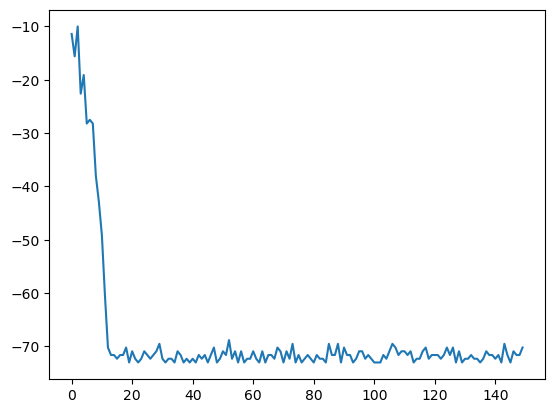

In [12]:
plt.plot(np.average(np.reshape(avg_scores,(-1,10)),axis=1))
#avg_scores.reshape(-1,10)


In [132]:
actions = 17
randomized = [i for i in range(actions)]


indices = [i for i in range(actions)]
randvalues = np.random.random(actions)


[8, 5, 0, 9, 11, 13, 6, 15, 1, 2, 3, 10, 4, 7, 16, 14, 12]

In [147]:
#Zip random values with indices
neuralOutput = dict(zip(f, randvalues))
#Sort neural output
neuralOutputSorted =sorted(neuralOutput,key=neuralOutput.get, reverse=True)


np.random.shuffle(randomized)


In [148]:
neuralOutputSorted

[12, 14, 16, 7, 4, 10, 3, 2, 1, 15, 6, 13, 11, 9, 0, 5, 8]

In [139]:
neuralOutput

{0: 0.15310188863708996,
 1: 0.5271760018710607,
 2: 0.6194156144867373,
 3: 0.6314140285126562,
 4: 0.842230267802151,
 5: 0.050855888297355656,
 6: 0.3709438764807429,
 7: 0.9221786572315427,
 8: 0.04515087605461876,
 9: 0.22459320785195036,
 10: 0.8255421553614024,
 11: 0.28754495166612426,
 12: 0.999245983653287,
 13: 0.3510052416469812,
 14: 0.9802852213612937,
 15: 0.4919925665363163,
 16: 0.964542259328261}